# Import des ressources

In [110]:
import pandas as pd
import missingno
import ast
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import FunctionTransformer
import folium


# Supprime les avertissements

# supprime les FutureWarnings dû à l'utilisation de pandas (.append/.drop)
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'

# fix pour plotly express et Visual Studio Code
import plotly.io as pio
pio.renderers.default = "notebook_connected"

# Import de la data

In [111]:
df_2015 = pd.read_csv("E:/bazar/Work/Work_OpenClassroom/Projet 4/2015-building-energy-benchmark.csv")
df_2016 = pd.read_csv("E:/bazar/Work/Work_OpenClassroom/Projet 4/2016-building-energy-benchmark.csv")

# Fonctions

## Fonctions de bases

In [112]:
def cellules_manquantes_pourcentage(data):
    # Permet d'avoir un % de cellules manquantes
    return data.isna().sum().sum()/(data.size)

## Fonctions sur les dataframes

In [113]:
def comparaisons_colonnes(list_1, list_2):
    # Compare les colonnes de deux listes, et renvoient celles qui ne sont pas présentes dans les deux fichiers
    # Un set est un ensemble de clefs non ordonnées et non redondant où l'on peut savoir
    # si un élément est présent sans avoir à parcourir toute la liste (une sorte de dictionnaire où les valeurs seraient ignorées, seules les clefs comptent).
    dif_list_1_list_2 = list(set(list_1) - set(list_2))
    dif_list_2_list_1 = list(set(list_2) - set(list_1))
    return dif_list_1_list_2, dif_list_2_list_1


def extraire_variables_imbriquees(df, colonne):
    # Vocabulaire à connaitre : liste/dictionnaire en compréhension
    df[colonne] = [ast.literal_eval(str(item)) for index, item in df[colonne].iteritems()]

    df = pd.concat([df.drop([colonne], axis=1), df[colonne].apply(pd.Series)], axis=1)
    return df


def supprimer_variables_peu_utilisables(data, condition):
    # Permet de supprimer les variables qui ont un nombre de données manquantes important. On calcule en fonction d'un % (condition)
    data_filtree = pd.DataFrame()
    data_filtree = data
    for column in data.columns:  # on boucle sur chaque colonne de la Dataframe
        var_type = data[column].dtypes  # on check le type de la colonne
        pourcentage_valeur_manquantes = cellules_manquantes_pourcentage(data[column])   # % de données manquant
        if var_type == 'float64' and float(pourcentage_valeur_manquantes) > condition:  # si le type n'est pas float, ça ne peut pas marcher.
            data_filtree.drop(column, axis=1, inplace=True)  # on drop l'intégralité de la colonne si le % manquant dépasse la condition...
            print(f'La colonne {column} , avec {pourcentage_valeur_manquantes*100} % de données manquantes de la Dataframe est supprimée')
    return data_filtree


def valeur_unique(df):
    for column in df.columns:
        if df[column].nunique() < 20:
            print('Colonne {}, valeurs uniques :\n{}\n'.format(column, df[column].unique()))
        else:
            print('Colonne {}, {} valeurs uniques'.format(column, df[column].nunique()))

### fonctions log

In [114]:
def echelle_logarithmique(df2, variable):
    # Objectif : voir mieux la distribution 'normale' des données

    np.seterr(divide='ignore')
    np.seterr(invalid='ignore')

    # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html
    # https://stackoverflow.com/questions/38466432/what-is-scikit-learn-functiontransformer-used-for
    # https://numpy.org/doc/stable/reference/generated/numpy.log.html
    # https://numpy.org/doc/stable/reference/generated/numpy.exp.html
    # https://www.techno-science.net/definition/2444.html
    '''Une échelle logarithmique est un système de graduation sur une demi-droite[Ox),
    particulièrement adapté pour rendre compte des ordres de grandeur dans les applications.
    De plus elle permet de rendre accessible une large gamme de valeurs.'''

    logtransformer = FunctionTransformer(np.log, inverse_func=np.exp, check_inverse=True)

    df_log = df2[['DataYear', variable]].dropna()

    df_log[variable] = logtransformer.transform(df_log[variable])

    return df_log

# Pré-analyse
## Jeu de données


In [115]:
pd.set_option("display.max_columns", 500)
df_2015.head(5)

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2015  NonResidential               Hotel   
1              2      2015  NonResidential               Hotel   
2              3      2015  NonResidential               Hotel   
3              5      2015  NonResidential               Hotel   
4              8      2015  NonResidential               Hotel   

            PropertyName TaxParcelIdentificationNumber  \
0   MAYFLOWER PARK HOTEL                     659000030   
1        PARAMOUNT HOTEL                     659000220   
2           WESTIN HOTEL                     659000475   
3              HOTEL MAX                     659000640   
4  WARWICK SEATTLE HOTEL                     659000970   

                                            Location  CouncilDistrictCode  \
0  {'latitude': '47.61219025', 'longitude': '-122...                    7   
1  {'latitude': '47.61310583', 'longitude': '-122...                    7   
2  {'latitude': '47.61334897', 'longitude': '-122...                    7   
3  {'latitude': '47.61421585', 'longitude': '-122...                    7   
4  {'latitude': '47.6137544', 'longitude': '-122....                    7   

  Neighborhood  YearBuilt  NumberofBuildings  NumberofFloors  \
0     DOWNTOWN       1927                  1            12.0   
1     DOWNTOWN       1996                  1            11.0   
2     DOWNTOWN       1969                  1            41.0   
3     DOWNTOWN       1926                  1            10.0   
4     DOWNTOWN       1980                  1            18.0   

   PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
0             88434                   0                   88434   
1            103566               15064                   88502   
2            961990                   0                  961990   
3             61320                   0                   61320   
4            119890               12460                  107430   

       ListOfAllPropertyUseTypes LargestPropertyUseType  \
0                          Hotel                  Hotel   
1     Hotel, Parking, Restaurant                  Hotel   
2  Hotel, Parking, Swimming Pool                  Hotel   
3                          Hotel                  Hotel   
4  Hotel, Parking, Swimming Pool                  Hotel   

   LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
0                    88434.0                          NaN   
1                    83880.0                      Parking   
2                   757243.0                      Parking   
3                    61320.0                          NaN   
4                   123445.0                      Parking   

   SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
0                              NaN                         NaN   
1                          15064.0                  Restaurant   
2                         100000.0               Swimming Pool   
3                              NaN                         NaN   
4                          68009.0               Swimming Pool   

   ThirdLargestPropertyUseTypeGFA YearsENERGYSTARCertified  ENERGYSTARScore  \
0                             NaN                      NaN             65.0   
1                          4622.0                      NaN             51.0   
2                             0.0                      NaN             18.0   
3                             NaN                      NaN              1.0   
4                             0.0                      NaN             67.0   

   SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  \
0              78.9                80.3               173.5   
1              94.4                99.0               191.3   
2              96.6                99.7               242.7   
3             460.4               462.5               636.3   
4             120.1               122.1               228.8   

   SourceEUIWN(kBtu/sf)  SiteEner

In [116]:
df_2015.info()
print(df_2015.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3340 entries, 0 to 3339
Data columns (total 47 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   OSEBuildingID                                                  3340 non-null   int64  
 1   DataYear                                                       3340 non-null   int64  
 2   BuildingType                                                   3340 non-null   object 
 3   PrimaryPropertyType                                            3340 non-null   object 
 4   PropertyName                                                   3340 non-null   object 
 5   TaxParcelIdentificationNumber                                  3338 non-null   object 
 6   Location                                                       3340 non-null   object 
 7   CouncilDistrictCode                                         

In [117]:
df_2016.head(5)
print(df_2016.shape)

(3376, 46)


In [118]:
df_2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

<span style="color: #00B0F0">Sans aller plus loin, on peut déjà voir que la structure des deux fichiers est différente.</span>

In [119]:
list_1 = list(df_2015.columns)
list_2 = list(df_2016.columns)

dif2015, dif2016 = comparaisons_colonnes(list_1, list_2)

In [120]:
print("Colonnes 2015, absentes de 2016 : " + str(dif2015) + "\n")
print("Colonnes 2016, absentes de 2015 : " + str(dif2016))


Colonnes 2015, absentes de 2016 : ['Comment', 'Zip Codes', 'OtherFuelUse(kBtu)', 'Location', 'SPD Beats', 'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)', '2010 Census Tracts', 'Seattle Police Department Micro Community Policing Plan Areas', 'City Council Districts']

Colonnes 2016, absentes de 2015 : ['Latitude', 'Longitude', 'State', 'Address', 'Comments', 'GHGEmissionsIntensity', 'City', 'ZipCode', 'TotalGHGEmissions']


# Ajustement des datasets

Afin de fusionner les deux datasets, il faut effectuer quelques ajustements...

## Location

In [121]:
df_2015['Location']

0       {'latitude': '47.61219025', 'longitude': '-122...
1       {'latitude': '47.61310583', 'longitude': '-122...
2       {'latitude': '47.61334897', 'longitude': '-122...
3       {'latitude': '47.61421585', 'longitude': '-122...
4       {'latitude': '47.6137544', 'longitude': '-122....
                              ...                        
3335    {'latitude': '47.59950256', 'longitude': '-122...
3336    {'latitude': '47.65752471', 'longitude': '-122...
3337    {'latitude': '47.61649845', 'longitude': '-122...
3338    {'latitude': '47.68396954', 'longitude': '-122...
3339    {'latitude': '47.68396954', 'longitude': '-122...
Name: Location, Length: 3340, dtype: object

In [122]:
df_2015['Location'][0]

'{\'latitude\': \'47.61219025\', \'longitude\': \'-122.33799744\', \'human_address\': \'{"address": "405 OLIVE WAY", "city": "SEATTLE", "state": "WA", "zip": "98101"}\'}'

In [123]:
df_2016[['Latitude', 'Longitude', 'City', 'Address', 'State', 'ZipCode']]

Latitude  Longitude     City           Address State  ZipCode
0     47.61220 -122.33799  Seattle     405 Olive way    WA  98101.0
1     47.61317 -122.33393  Seattle   724 Pine street    WA  98101.0
2     47.61393 -122.33810  Seattle   1900 5th Avenue    WA  98101.0
3     47.61412 -122.33664  Seattle    620 STEWART ST    WA  98101.0
4     47.61375 -122.34047  Seattle     401 LENORA ST    WA  98121.0
...        ...        ...      ...               ...   ...      ...
3371  47.56722 -122.31154  Seattle  1600 S Dakota St    WA      NaN
3372  47.59625 -122.32283  Seattle     719 8th Ave S    WA      NaN
3373  47.63644 -122.35784  Seattle    1920 1st Ave W    WA      NaN
3374  47.52832 -122.32431  Seattle    8319 8th Ave S    WA      NaN
3375  47.53939 -122.29536  Seattle  2820 S Myrtle St    WA      NaN

[3376 rows x 6 columns]

In [124]:
# ast.literal_eval permet de supprimer tous les caractères "parasites"
print(ast.literal_eval(str(df_2015['Location'][0])))

{'latitude': '47.61219025', 'longitude': '-122.33799744', 'human_address': '{"address": "405 OLIVE WAY", "city": "SEATTLE", "state": "WA", "zip": "98101"}'}


<span style="color: #FF7F00">On voit que la forme ici est différente... en 2015, c'est un dictionnaire (voire même un double dictionnaire). En 2016, ce sont plusieurs variables différentes.</span>

<span style="color: #26B260">Il faut donc décomposer ce dictionnaire, et transformer cela en variables.</span>

In [125]:
df_2015 = extraire_variables_imbriquees(df_2015, 'Location')


df_2015.head()

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2015  NonResidential               Hotel   
1              2      2015  NonResidential               Hotel   
2              3      2015  NonResidential               Hotel   
3              5      2015  NonResidential               Hotel   
4              8      2015  NonResidential               Hotel   

            PropertyName TaxParcelIdentificationNumber  CouncilDistrictCode  \
0   MAYFLOWER PARK HOTEL                     659000030                    7   
1        PARAMOUNT HOTEL                     659000220                    7   
2           WESTIN HOTEL                     659000475                    7   
3              HOTEL MAX                     659000640                    7   
4  WARWICK SEATTLE HOTEL                     659000970                    7   

  Neighborhood  YearBuilt  NumberofBuildings  NumberofFloors  \
0     DOWNTOWN       1927                  1            12.0   
1     DOWNTOWN       1996                  1            11.0   
2     DOWNTOWN       1969                  1            41.0   
3     DOWNTOWN       1926                  1            10.0   
4     DOWNTOWN       1980                  1            18.0   

   PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
0             88434                   0                   88434   
1            103566               15064                   88502   
2            961990                   0                  961990   
3             61320                   0                   61320   
4            119890               12460                  107430   

       ListOfAllPropertyUseTypes LargestPropertyUseType  \
0                          Hotel                  Hotel   
1     Hotel, Parking, Restaurant                  Hotel   
2  Hotel, Parking, Swimming Pool                  Hotel   
3                          Hotel                  Hotel   
4  Hotel, Parking, Swimming Pool                  Hotel   

   LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
0                    88434.0                          NaN   
1                    83880.0                      Parking   
2                   757243.0                      Parking   
3                    61320.0                          NaN   
4                   123445.0                      Parking   

   SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
0                              NaN                         NaN   
1                          15064.0                  Restaurant   
2                         100000.0               Swimming Pool   
3                              NaN                         NaN   
4                          68009.0               Swimming Pool   

   ThirdLargestPropertyUseTypeGFA YearsENERGYSTARCertified  ENERGYSTARScore  \
0                             NaN                      NaN             65.0   
1                          4622.0                      NaN             51.0   
2                             0.0                      NaN             18.0   
3                             NaN                      NaN              1.0   
4                             0.0                      NaN             67.0   

   SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  \
0              78.9                80.3               173.5   
1              94.4                99.0               191.3   
2              96.6                99.7               242.7   
3             460.4               462.5               636.3   
4             120.1               122.1               228.8   

   SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  \
0                 175.1            6981428.0              7097539.0   
1                 195.2            8354235.0              8765788.0   
2                 246.5           73130656.0             75506272.0   
3                 643.2           28229320.0             28363444.0   
4              

### HumanAddress
<span style="color: #26B260">Dans le dictionnaire 'Location", il y a un second dictionnaire -> Human_address.
On refait la même étape ...</span>

In [126]:
df_2015 = extraire_variables_imbriquees(df_2015, 'human_address')


df_2015.head()

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2015  NonResidential               Hotel   
1              2      2015  NonResidential               Hotel   
2              3      2015  NonResidential               Hotel   
3              5      2015  NonResidential               Hotel   
4              8      2015  NonResidential               Hotel   

            PropertyName TaxParcelIdentificationNumber  CouncilDistrictCode  \
0   MAYFLOWER PARK HOTEL                     659000030                    7   
1        PARAMOUNT HOTEL                     659000220                    7   
2           WESTIN HOTEL                     659000475                    7   
3              HOTEL MAX                     659000640                    7   
4  WARWICK SEATTLE HOTEL                     659000970                    7   

  Neighborhood  YearBuilt  NumberofBuildings  NumberofFloors  \
0     DOWNTOWN       1927                  1            12.0   
1     DOWNTOWN       1996                  1            11.0   
2     DOWNTOWN       1969                  1            41.0   
3     DOWNTOWN       1926                  1            10.0   
4     DOWNTOWN       1980                  1            18.0   

   PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
0             88434                   0                   88434   
1            103566               15064                   88502   
2            961990                   0                  961990   
3             61320                   0                   61320   
4            119890               12460                  107430   

       ListOfAllPropertyUseTypes LargestPropertyUseType  \
0                          Hotel                  Hotel   
1     Hotel, Parking, Restaurant                  Hotel   
2  Hotel, Parking, Swimming Pool                  Hotel   
3                          Hotel                  Hotel   
4  Hotel, Parking, Swimming Pool                  Hotel   

   LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
0                    88434.0                          NaN   
1                    83880.0                      Parking   
2                   757243.0                      Parking   
3                    61320.0                          NaN   
4                   123445.0                      Parking   

   SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
0                              NaN                         NaN   
1                          15064.0                  Restaurant   
2                         100000.0               Swimming Pool   
3                              NaN                         NaN   
4                          68009.0               Swimming Pool   

   ThirdLargestPropertyUseTypeGFA YearsENERGYSTARCertified  ENERGYSTARScore  \
0                             NaN                      NaN             65.0   
1                          4622.0                      NaN             51.0   
2                             0.0                      NaN             18.0   
3                             NaN                      NaN              1.0   
4                             0.0                      NaN             67.0   

   SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  \
0              78.9                80.3               173.5   
1              94.4                99.0               191.3   
2              96.6                99.7               242.7   
3             460.4               462.5               636.3   
4             120.1               122.1               228.8   

   SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  \
0                 175.1            6981428.0              7097539.0   
1                 195.2            8354235.0              8765788.0   
2                 246.5           73130656.0             75506272.0   
3                 643.2           28229320.0             28363444.0   
4              

## GHGEmissions

In [127]:
def df_describe(df, colonne):
    print(colonne + " : \n")
    print(str(df[colonne].describe()) + "\n")


print('2015 :')
df_describe(df_2015, 'GHGEmissions(MetricTonsCO2e)')
df_describe(df_2015, 'GHGEmissionsIntensity(kgCO2e/ft2)')

print('2016 :')
df_describe(df_2016, 'TotalGHGEmissions')
df_describe(df_2016, 'GHGEmissionsIntensity')



2015 :
GHGEmissions(MetricTonsCO2e) : 

count     3330.000000
mean       110.094102
std        409.450179
min          0.000000
25%          9.265000
50%         32.740000
75%         88.642500
max      11824.890000
Name: GHGEmissions(MetricTonsCO2e), dtype: float64

GHGEmissionsIntensity(kgCO2e/ft2) : 

count    3330.000000
mean        0.985339
std         1.637172
min         0.000000
25%         0.080000
50%         0.460000
75%         1.180000
max        31.380000
Name: GHGEmissionsIntensity(kgCO2e/ft2), dtype: float64

2016 :
TotalGHGEmissions : 

count     3367.000000
mean       119.723971
std        538.832227
min         -0.800000
25%          9.495000
50%         33.920000
75%         93.940000
max      16870.980000
Name: TotalGHGEmissions, dtype: float64

GHGEmissionsIntensity : 

count    3367.000000
mean        1.175916
std         1.821452
min        -0.020000
25%         0.210000
50%         0.610000
75%         1.370000
max        34.090000
Name: GHGEmissionsIntensity, 

Les variables ont l'air identiques, mais les noms sont différents...

## Colonnes

### Noms

On résout le soucis, vu dans le point précédent...

In [128]:
df_2015 = df_2015.rename(columns={'GHGEmissions(MetricTonsCO2e)': 'TotalGHGEmissions',
                                  'GHGEmissionsIntensity(kgCO2e/ft2)': 'GHGEmissionsIntensity'})

In [129]:
print(df_2015.columns)

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'TaxParcelIdentificationNumber', 'CouncilDistrictCode',
       'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'OtherFuelUse(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity',
       'DefaultData', 'Comment', 'ComplianceStatus', 'Outlier',
 

In [130]:
print(df_2016.columns)

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'DefaultData', 'Comments', 'ComplianceStatus',
       'Outlier

Des noms sont identiques, mais il manque une majuscule ...

In [131]:
df_2015 = df_2015.rename(columns={"latitude": "Latitude",
                                  "longitude": "Longitude",
                                  "address": "Address",
                                  "city": "City",
                                  "state": "State",
                                  "zip": "ZipCode"})

### Types

In [132]:
pd.DataFrame([df_2015.dtypes, df_2016.dtypes])

OSEBuildingID DataYear BuildingType PrimaryPropertyType PropertyName  \
0         int64    int64       object              object       object   
1         int64    int64       object              object       object   

  TaxParcelIdentificationNumber CouncilDistrictCode Neighborhood YearBuilt  \
0                        object               int64       object     int64   
1                        object               int64       object     int64   

  NumberofBuildings NumberofFloors PropertyGFATotal PropertyGFAParking  \
0             int64        float64            int64              int64   
1           float64          int64            int64              int64   

  PropertyGFABuilding(s) ListOfAllPropertyUseTypes LargestPropertyUseType  \
0                  int64                    object                 object   
1                  int64                    object                 object   

  LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
0                   float64                       object   
1                   float64                       object   

  SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
0                         float64                      object   
1                         float64                      object   

  ThirdLargestPropertyUseTypeGFA YearsENERGYSTARCertified ENERGYSTARScore  \
0                        float64                   object         float64   
1                        float64                   object         float64   

  SiteEUI(kBtu/sf) SiteEUIWN(kBtu/sf) SourceEUI(kBtu/sf) SourceEUIWN(kBtu/sf)  \
0          float64            float64            float64              float64   
1          float64            float64            float64              float64   

  SiteEnergyUse(kBtu) SiteEnergyUseWN(kBtu) SteamUse(kBtu) Electricity(kWh)  \
0             float64               float64        float64          float64   
1             float64               float64        float64          float64   

  Electricity(kBtu) NaturalGas(therms) NaturalGas(kBtu) OtherFuelUse(kBtu)  \
0           float64            float64          float64            float64   
1           float64            float64          float64                NaN   

  TotalGHGEmissions GHGEmissionsIntensity DefaultData Comment  \
0           float64               float64      object  object   
1           float64               float64        bool     NaN   

  ComplianceStatus Outlier 2010 Census Tracts  \
0           object  object            float64   
1           object  object                NaN   

  Seattle Police Department Micro Community Policing Plan Areas  \
0                                            float64              
1                                                NaN              

  City Council Districts SPD Beats Zip Codes Latitude Longitude Address  \
0                float64   float64     int64   object    object  object   
1                    NaN       NaN       NaN  float64   float64  object   

     City   State  ZipCode Comments  
0  object  object   object      NaN  
1  object  object  float64  float64

Des colonnes importantes n'ont pas le même type, on corrige ...

In [133]:
df_2015[['Latitude', 'Longitude', 'ZipCode']] = df_2015[['Latitude', 'Longitude', 'ZipCode']].astype('float64')


<span style="color: #26B260">On peut désormais fusionner ! :)</span>

# Fusion du dataset

In [134]:
df = pd.concat([df_2015, df_2016])

In [135]:
df

OSEBuildingID  DataYear        BuildingType PrimaryPropertyType  \
0                 1      2015      NonResidential               Hotel   
1                 2      2015      NonResidential               Hotel   
2                 3      2015      NonResidential               Hotel   
3                 5      2015      NonResidential               Hotel   
4                 8      2015      NonResidential               Hotel   
...             ...       ...                 ...                 ...   
3371          50222      2016  Nonresidential COS              Office   
3372          50223      2016  Nonresidential COS               Other   
3373          50224      2016  Nonresidential COS               Other   
3374          50225      2016  Nonresidential COS  Mixed Use Property   
3375          50226      2016  Nonresidential COS  Mixed Use Property   

                             PropertyName TaxParcelIdentificationNumber  \
0                    MAYFLOWER PARK HOTEL                     659000030   
1                         PARAMOUNT HOTEL                     659000220   
2                            WESTIN HOTEL                     659000475   
3                               HOTEL MAX                     659000640   
4                   WARWICK SEATTLE HOTEL                     659000970   
...                                   ...                           ...   
3371                Horticulture building                    1624049080   
3372  International district/Chinatown CC                    3558300000   
3373                      Queen Anne Pool                    1794501150   
3374          South Park Community Center                    7883603155   
3375          Van Asselt Community Center                    7857002030   

      CouncilDistrictCode           Neighborhood  YearBuilt  \
0                       7               DOWNTOWN       1927   
1                       7               DOWNTOWN       1996   
2                       7               DOWNTOWN       1969   
3                       7               DOWNTOWN       1926   
4                       7               DOWNTOWN       1980   
...                   ...                    ...        ...   
3371                    2       GREATER DUWAMISH       1990   
3372                    2               DOWNTOWN       2004   
3373                    7  MAGNOLIA / QUEEN ANNE       1974   
3374                    1       GREATER DUWAMISH       1989   
3375                    2       GREATER DUWAMISH       1938   

      NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
0                   1.0            12.0             88434                   0   
1                   1.0            11.0            103566               15064   
2                   1.0            41.0            961990                   0   
3                   1.0            10.0             61320                   0   
4                   1.0            18.0            119890               12460   
...                 ...             ...               ...                 ...   
3371                1.0             1.0             12294                   0   
3372                1.0             1.0             16000                   0   
3373                1.0             1.0             13157                   0   
3374                1.0             1.0             14101                   0   
3375                1.0             1.0             18258                   0   

      PropertyGFABuilding(s)  \
0                      88434   
1                      88502   
2                     961990   
3                      61320   
4                     107430   
...                      ...   
3371                   12294   
3372                   16000   
3373                   13157   
3374                   14101   
3375                   18258   

                              ListOfAllPropertyUseTypes  \
0                                                 Hote

## Valeurs manquantes

<AxesSubplot:>

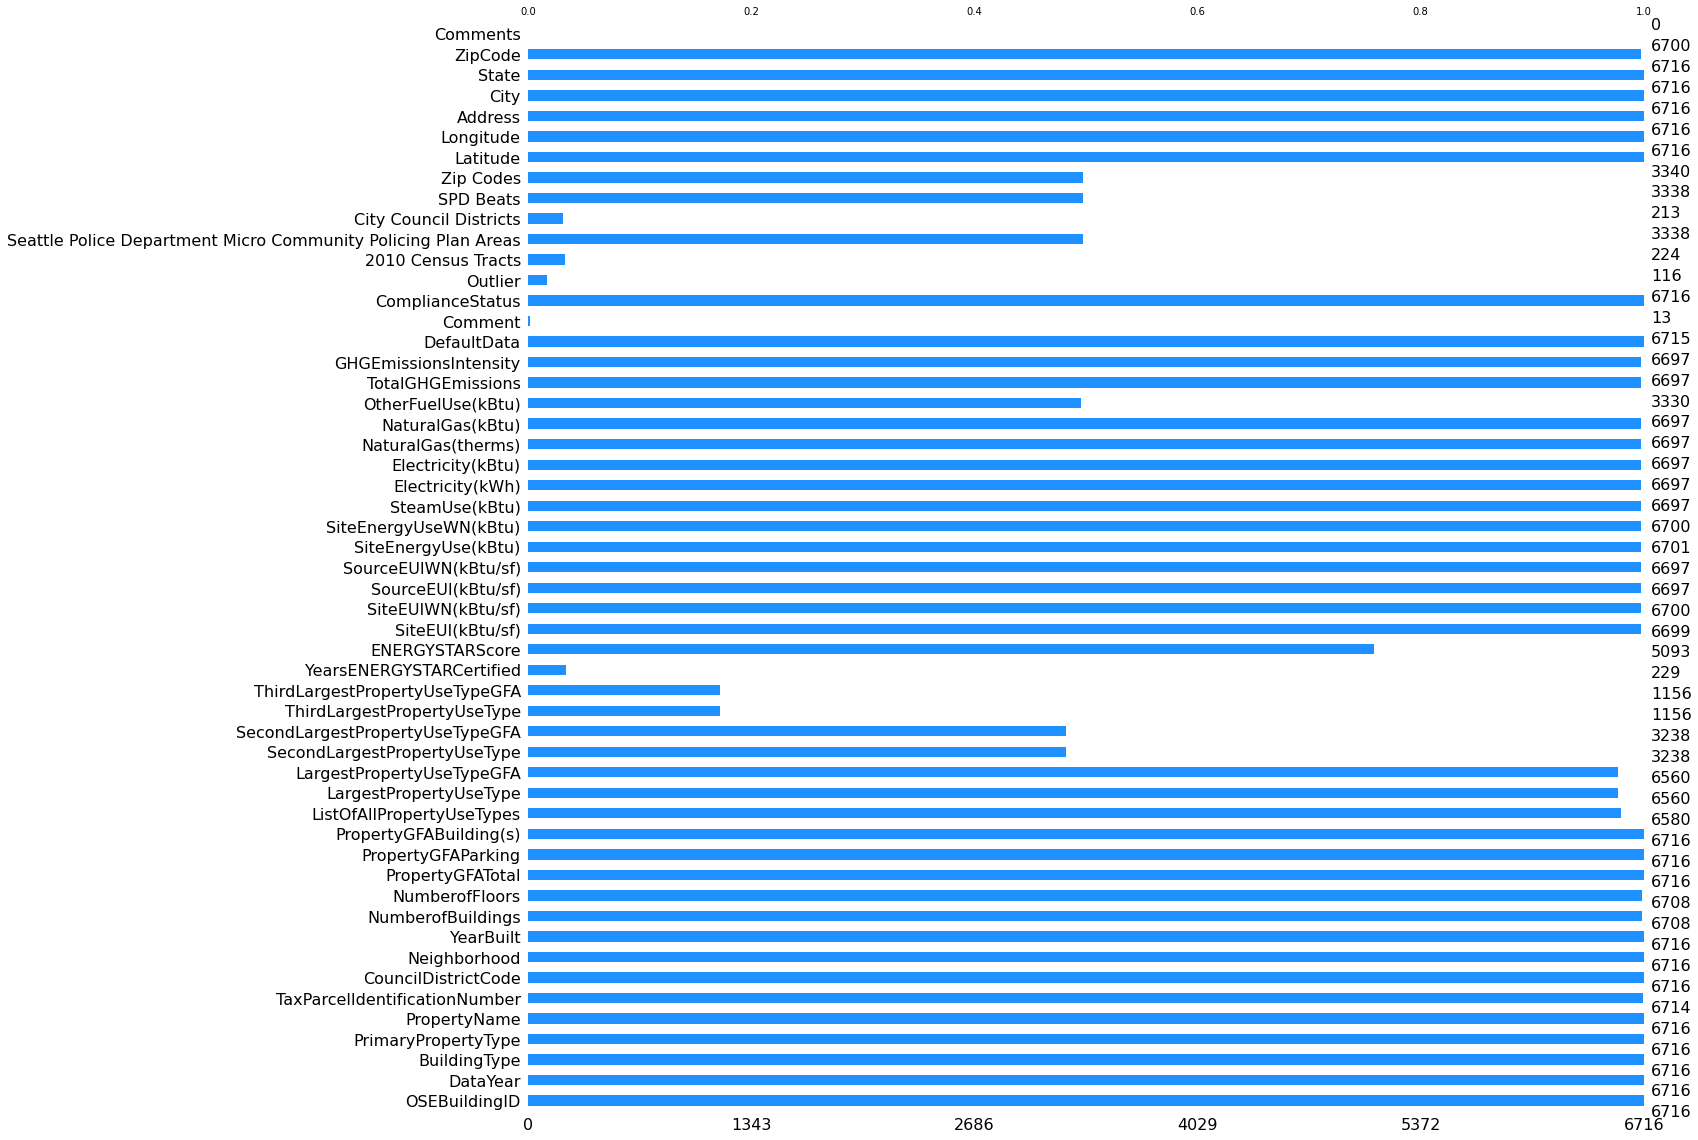

In [136]:
missingno.bar(df, color='dodgerblue', figsize=(20, 20))

# Nettoyage...

## Doublons
### Vue générale

In [137]:
print(df.loc[df.duplicated(keep=False), :])

Empty DataFrame
Columns: [OSEBuildingID, DataYear, BuildingType, PrimaryPropertyType, PropertyName, TaxParcelIdentificationNumber, CouncilDistrictCode, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ListOfAllPropertyUseTypes, LargestPropertyUseType, LargestPropertyUseTypeGFA, SecondLargestPropertyUseType, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseType, ThirdLargestPropertyUseTypeGFA, YearsENERGYSTARCertified, ENERGYSTARScore, SiteEUI(kBtu/sf), SiteEUIWN(kBtu/sf), SourceEUI(kBtu/sf), SourceEUIWN(kBtu/sf), SiteEnergyUse(kBtu), SiteEnergyUseWN(kBtu), SteamUse(kBtu), Electricity(kWh), Electricity(kBtu), NaturalGas(therms), NaturalGas(kBtu), OtherFuelUse(kBtu), TotalGHGEmissions, GHGEmissionsIntensity, DefaultData, Comment, ComplianceStatus, Outlier, 2010 Census Tracts, Seattle Police Department Micro Community Policing Plan Areas, City Council Districts, SPD Beats, Zip Codes, Latitude, Longitude, Addre

### Par batiment 
On a fusionné 2015 + 2016... <span style="color: #FF7F00">Il y a forcément des batiments qu'on a deux fois</span>

In [138]:
df[df.duplicated(subset=['OSEBuildingID'])]

OSEBuildingID  DataYear          BuildingType    PrimaryPropertyType  \
0                 1      2016        NonResidential                  Hotel   
1                 2      2016        NonResidential                  Hotel   
2                 3      2016        NonResidential                  Hotel   
3                 5      2016        NonResidential                  Hotel   
4                 8      2016        NonResidential                  Hotel   
...             ...       ...                   ...                    ...   
3327          50049      2016  Multifamily LR (1-4)   Low-Rise Multifamily   
3330          50055      2016  Multifamily MR (5-9)   Mid-Rise Multifamily   
3333          50057      2016  Multifamily HR (10+)  High-Rise Multifamily   
3334          50058      2016  Multifamily LR (1-4)   Low-Rise Multifamily   
3335          50059      2016  Multifamily LR (1-4)   Low-Rise Multifamily   

                              PropertyName TaxParcelIdentificationNumber  \
0                     Mayflower park hotel                    0659000030   
1                          Paramount Hotel                    0659000220   
2                  5673-The Westin Seattle                    0659000475   
3                                HOTEL MAX                    0659000640   
4              WARWICK SEATTLE HOTEL (ID8)                    0659000970   
...                                    ...                           ...   
3327  PACIFIC CENTER CONDOMINIUM (ID50049)                    6599950000   
3330  129610 - Identity Seattle Building D                    1142001670   
3333                                Cirrus                    0660000575   
3334          Wedgewood Estates Building A                    6392001040   
3335          Wedgewood Estates Building B                    6392001040   

      CouncilDistrictCode Neighborhood  YearBuilt  NumberofBuildings  \
0                       7     DOWNTOWN       1927                1.0   
1                       7     DOWNTOWN       1996                1.0   
2                       7     DOWNTOWN       1969                1.0   
3                       7     DOWNTOWN       1926                1.0   
4                       7     DOWNTOWN       1980                1.0   
...                   ...          ...        ...                ...   
3327                    2     DOWNTOWN       2000                1.0   
3330                    4    NORTHEAST       2014                2.0   
3333                    7     DOWNTOWN       2015                1.0   
3334                    4    NORTHEAST       1981                1.0   
3335                    4    NORTHEAST       1981                1.0   

      NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
0               12.0             88434                   0   
1               11.0            103566               15064   
2               41.0            956110              196718   
3               10.0             61320                   0   
4               18.0            175580               62000   
...              ...               ...                 ...   
3327             4.0             44650                   0   
3330             7.0             42393                   0   
3333            40.0            319481               41915   
3334             3.0             48230                   0   
3335             4.0             53100                   0   

      PropertyGFABuilding(s)  \
0                      88434   
1                      88502   
2                     759392   
3                      61320   
4                     113580   
...                      ...   
3327                   44650   
3330                   42393   
3333                  277566   
3334                   48230   
3335                   53100   

                              ListOfAllPropertyUseTypes  \
0                                                 Hotel   
1                            Hotel, Parking

Il y a environ 3300 informations sur un même batiment

## Type de batiments
L'énoncé indique "votre équipe s’intéresse de près aux émissions des bâtiments non destinés à l’habitation."
Cela implique qu'il faut écarter les autres types de batiment



In [139]:
df['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Multifamily LR (1-4)', 'Campus',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

### Répartition
Avant toute modification, il convient de faire afficher la répartition pour ne pas perdre l'information.

In [140]:
fig = px.pie(df, names='BuildingType')
fig.show()

In [141]:
# On supprime ce qui ne nous intéresse pas selon l'énoncé
df = df[~df['BuildingType'].str.contains('Multifamily')]
df['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'SPS-District K-12',
       'Campus', 'Nonresidential WA'], dtype=object)

## Colonnes inutiles
Certaines colonnes sont soit vides, soit inutiles. On va d'abord supprimer les colonnes avec peu de données automatiquement, puis en supprimer arbitrairement.

In [142]:
# On ne s'intéresse qu'à supprimer les valeurs chiffrées... Il y a peut-être des particularités intéressantes
# dans les colonnes textuelles
df = supprimer_variables_peu_utilisables(df, 0.7)




La colonne ThirdLargestPropertyUseTypeGFA , avec 79.38517179023508 % de données manquantes de la Dataframe est supprimée
La colonne 2010 Census Tracts , avec 97.34779987944545 % de données manquantes de la Dataframe est supprimée
La colonne City Council Districts , avec 97.55877034358048 % de données manquantes de la Dataframe est supprimée
La colonne Comments , avec 100.0 % de données manquantes de la Dataframe est supprimée


In [143]:
# On regarde ce qu'on a, à disposition...
valeur_unique(df)

Colonne OSEBuildingID, 1698 valeurs uniques
Colonne DataYear, valeurs uniques :
[2015 2016]

Colonne BuildingType, valeurs uniques :
['NonResidential' 'Nonresidential COS' 'SPS-District K-12' 'Campus'
 'Nonresidential WA']

Colonne PrimaryPropertyType, 30 valeurs uniques
Colonne PropertyName, 3204 valeurs uniques
Colonne TaxParcelIdentificationNumber, 1835 valeurs uniques
Colonne CouncilDistrictCode, valeurs uniques :
[7 3 2 4 5 6 1]

Colonne Neighborhood, valeurs uniques :
['DOWNTOWN' 'SOUTHEAST' 'NORTHEAST' 'EAST' 'CENTRAL' 'NORTH'
 'MAGNOLIA / QUEEN ANNE' 'LAKE UNION' 'GREATER DUWAMISH' 'BALLARD'
 'NORTHWEST' 'SOUTHWEST' 'DELRIDGE' 'Central' 'Ballard' 'North' 'Delridge'
 'Northwest' 'DELRIDGE NEIGHBORHOODS']

Colonne YearBuilt, 113 valeurs uniques
Colonne NumberofBuildings, valeurs uniques :
[  1.   7.  11.  16.   4.   3.  39.   2.  10.   6.   0.  27.  14.   9.
   5.  nan   8.  23. 111.]

Colonne NumberofFloors, 45 valeurs uniques
Colonne PropertyGFATotal, 1667 valeurs uniques
Colon

In [144]:
# Arbitrairement
df = df.drop(['Comment', 'Outlier', 'DefaultData', 'CouncilDistrictCode'], axis=1)

# Il n'y a qu'une valeur pour cette variable, on peut la supprimer

df = df.drop(columns='State')

# idem ici... c'est Seattle..

df = df.drop(columns='City')

# nous avons la colonne ID, donc certaines colonnes "identifiants" ne sont plus utiles

df = df.drop(['PropertyName', 'TaxParcelIdentificationNumber'], axis=1)

# l'adresse n'apporte rien, nous avons la longitude/latitude qui peuvent être plus parlantes sur un plan :

df = df.drop(columns='Address')

# Donne des infos sur l'état des données, on s'en fiche ...

df = df.drop(columns='ComplianceStatus')

# Les variables WN (Weather Normalized) ne sont pas forcément très utiles ici, on va préférer travailler sur les stats brutes

df = df.drop(['SourceEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)', 'SiteEUIWN(kBtu/sf)'], axis=1)

# Les données "par surface" peuvent également être supprimés car nous souhaitons travailler sur les données brutes

df = df.drop(['SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)'], axis=1)



In [145]:
print(df['YearsENERGYSTARCertified'].unique())

# Trop peu de données ..

df = df.drop(columns='YearsENERGYSTARCertified')

[nan '2016' '2014' '2012' '2015'
 '2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008' '2010, 2009, 2007'
 '2010, 2007' '2016, 2015' '2017, 2015' '2015, 2014, 2012, 2011, 2009'
 '2012, 2009, 2008' '2016, 2015, 2014, 2013, 2011, 2010, 2009, 2007, 2000'
 '2016, 2009, 2008' '2016, 2014, 2012' '2016, 2015, 2014, 2012, 2008'
 '2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005, 2004'
 '2014, 2013, 2011, 2010, 2009, 2008, 2007'
 '2016, 2015, 2014, 2013, 2011, 2008' '2016, 2015, 2014, 2013, 2008'
 '2016, 2015, 2013, 2012, 2010' '2015, 2013, 2012, 2010' '2007' '2010'
 '2016, 2015, 2009, 2008' '2013, 2009, 2008' '2017'
 '2017, 2011, 2010, 2007'
 '2017, 2016, 2014, 2013, 2012, 2011, 2010, 2009, 2007'
 '2015, 2014, 2012, 2010, 2008' '2012, 2010, 2009, 2008' '2009, 2005'
 '2017, 2015, 2014, 2013' '2016, 2015, 2012' '2012, 2010, 2007, 2006'
 '2011, 2009' '2009' '2016, 2015, 2014, 2013, 2009, 2008'
 '2016, 2015, 2014, 2013, 2011, 2009' '2017, 2016, 2012' '2010, 2008'
 '2016, 20

## Données à retirer selon énoncé
<span style="color: #00B0F0">L'énoncé indique : "L’objectif est de te passer des relevés de consommation annuels (attention à la fuite de données)" donc :</span>


### Corrélation

Etant donné que les colonnes que l'on va supprimer, sont importantes dans notre prédiction finale... On va faire une matrice de corrélation avant de les supprimer.

<function matplotlib.pyplot.show(close=None, block=None)>

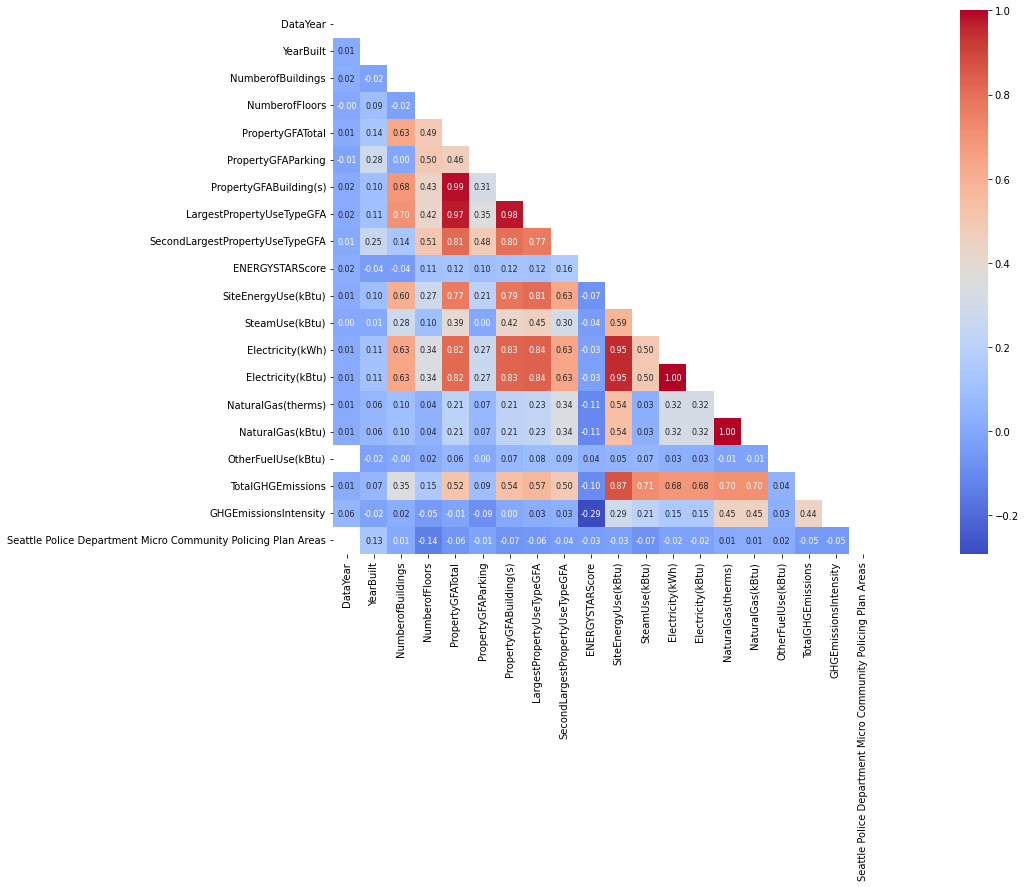

In [146]:
plt.figure(figsize=(30, 10))

# On va en revanche retirer les colonnes qui n'ont aucun sens à observer une corrélation...

corr_matrix = df.drop(['OSEBuildingID', 'ZipCode', 'Zip Codes', 'Latitude', 'Longitude', 'SPD Beats'], axis=1).corr()

mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr_matrix, mask=mask, square=True, cmap='coolwarm', annot=True, fmt=".2f", annot_kws={'size': 8})
plt.show

### Suppression

In [147]:
# On supprime ...

df = df.drop(['SteamUse(kBtu)', 'Electricity(kWh)',
              'Electricity(kBtu)', 'NaturalGas(therms)',
              'NaturalGas(kBtu)', 'GHGEmissionsIntensity'], axis=1)

## Harmonisation des données

In [148]:
# Dans la colonne Neightbours, parfois c'est en majuscule, parfois pas... On harmonise :

df['Neighborhood'] = df['Neighborhood'].map(lambda x: x.upper())

df['Neighborhood'].unique()

array(['DOWNTOWN', 'SOUTHEAST', 'NORTHEAST', 'EAST', 'CENTRAL', 'NORTH',
       'MAGNOLIA / QUEEN ANNE', 'LAKE UNION', 'GREATER DUWAMISH',
       'BALLARD', 'NORTHWEST', 'SOUTHWEST', 'DELRIDGE',
       'DELRIDGE NEIGHBORHOODS'], dtype=object)

In [149]:
# Delridge = Delridge neighboorhoods ... On harmonise à nouveau
df['Neighborhood'].replace('DELRIDGE NEIGHBORHOODS', 'DELRIDGE', inplace=True)

## Outliers

In [150]:
df.describe()

OSEBuildingID     DataYear    YearBuilt  NumberofBuildings  \
count    3318.000000  3318.000000  3318.000000        3316.000000   
mean    15951.816154  2015.502712  1961.536769           1.117310   
std     13411.897096     0.500068    32.709772           2.219845   
min         1.000000  2015.000000  1900.000000           0.000000   
25%       579.000000  2015.000000  1930.000000           1.000000   
50%     21122.000000  2016.000000  1965.000000           1.000000   
75%     24556.750000  2016.000000  1989.000000           1.000000   
max     50226.000000  2016.000000  2015.000000         111.000000   

       NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
count     3310.000000      3.318000e+03         3318.000000   
mean         4.126888      1.156672e+05        13303.304702   
std          6.567333      2.511222e+05        43596.620503   
min          0.000000      1.128500e+04           -2.000000   
25%          1.000000      2.951225e+04            0.000000   
50%          2.000000      4.924600e+04            0.000000   
75%          4.000000      1.047860e+05            0.000000   
max         99.000000      9.320156e+06       512608.000000   

       PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  \
count            3.318000e+03               3.247000e+03   
mean             1.023639e+05               9.539352e+04   
std              2.340749e+05               2.274274e+05   
min             -5.055000e+04               5.656000e+03   
25%              2.850775e+04               2.550000e+04   
50%              4.736800e+04               4.320000e+04   
75%              9.447150e+04               9.000000e+04   
max              9.320156e+06               9.320156e+06   

       SecondLargestPropertyUseTypeGFA  ENERGYSTARScore  SiteEnergyUse(kBtu)  \
count                      1667.000000      2211.000000         3.309000e+03   
mean                      36144.703237        64.815920         8.068625e+06   
std                       68243.536838        28.549886         2.525462e+07   
min                           0.000000         1.000000         0.000000e+00   
25%                        5400.000000        47.000000         1.223425e+06   
50%                       12102.000000        72.000000         2.505271e+06   
75%                       31190.500000        89.000000         6.917280e+06   
max                      686750.000000       100.000000         8.739237e+08   

       OtherFuelUse(kBtu)  TotalGHGEmissions  \
count        1.643000e+03        3309.000000   
mean         1.428036e+04         177.038779   
std          2.792388e+05         666.442480   
min          0.000000e+00          -0.800000   
25%          0.000000e+00          19.720000   
50%          0.000000e+00          49.160000   
75%          0.000000e+00         138.870000   
max          8.269669e+06       16870.980000   

       Seattle Police Department Micro Community Policing Plan Areas  \
count                                        1649.000000               
mean                                           34.586416               
std                                            19.570633               
min                                             1.000000               
25%                                            14.000000               
50%                                            35.000000               
75%                                            55.000000               
max                                            61.000000               

         SPD Beats     Zip Codes     Latitude    Longitude       ZipCode  
count  1649.000000   1650.000000  3318.000000  3318.000000   3302.000000  
mean     25.601577  18771.676970    47.616006  -122.333051  98116.579952  
std      13.905394    592.937939     0.048102     0.024535     17.071800  
min       1.000000  17916.000000    47.499170  -122.411820  98006.000000  
25%      12.000000  18379.000000    47.585595  -122.343357  98104.000000  
50%      27.000000  183

In [151]:
print(df['NumberofBuildings'].median())
print(df['NumberofFloors'].median())

1.0
2.0


### Nombre d'étages
<span style="color: #FF7F00">Il ne peut pas y avoir 0 ou NaN étages ou batiments... Ce n'est pas possible.</span>

In [152]:
df['NumberofBuildings'] = np.where(df['NumberofBuildings'] == 0, df['NumberofBuildings'].median(), df['NumberofBuildings'])
df['NumberofBuildings'] = df['NumberofBuildings'].fillna(df['NumberofBuildings'].median())

df['NumberofFloors'] = df['NumberofFloors'].fillna(df['NumberofFloors'].median())


# df['NumberofFloors'] = np.where(df['NumberofFloors'].isna(), 1, df['NumberofFloors'])  # combien ?
# Regarder le type de batiment (moyenne de la catégorie par ex)

df.describe()

OSEBuildingID     DataYear    YearBuilt  NumberofBuildings  \
count    3318.000000  3318.000000  3318.000000        3318.000000   
mean    15951.816154  2015.502712  1961.536769           1.132911   
std     13411.897096     0.500068    32.709772           2.214758   
min         1.000000  2015.000000  1900.000000           1.000000   
25%       579.000000  2015.000000  1930.000000           1.000000   
50%     21122.000000  2016.000000  1965.000000           1.000000   
75%     24556.750000  2016.000000  1989.000000           1.000000   
max     50226.000000  2016.000000  2015.000000         111.000000   

       NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
count     3318.000000      3.318000e+03         3318.000000   
mean         4.121760      1.156672e+05        13303.304702   
std          6.560238      2.511222e+05        43596.620503   
min          0.000000      1.128500e+04           -2.000000   
25%          1.000000      2.951225e+04            0.000000   
50%          2.000000      4.924600e+04            0.000000   
75%          4.000000      1.047860e+05            0.000000   
max         99.000000      9.320156e+06       512608.000000   

       PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  \
count            3.318000e+03               3.247000e+03   
mean             1.023639e+05               9.539352e+04   
std              2.340749e+05               2.274274e+05   
min             -5.055000e+04               5.656000e+03   
25%              2.850775e+04               2.550000e+04   
50%              4.736800e+04               4.320000e+04   
75%              9.447150e+04               9.000000e+04   
max              9.320156e+06               9.320156e+06   

       SecondLargestPropertyUseTypeGFA  ENERGYSTARScore  SiteEnergyUse(kBtu)  \
count                      1667.000000      2211.000000         3.309000e+03   
mean                      36144.703237        64.815920         8.068625e+06   
std                       68243.536838        28.549886         2.525462e+07   
min                           0.000000         1.000000         0.000000e+00   
25%                        5400.000000        47.000000         1.223425e+06   
50%                       12102.000000        72.000000         2.505271e+06   
75%                       31190.500000        89.000000         6.917280e+06   
max                      686750.000000       100.000000         8.739237e+08   

       OtherFuelUse(kBtu)  TotalGHGEmissions  \
count        1.643000e+03        3309.000000   
mean         1.428036e+04         177.038779   
std          2.792388e+05         666.442480   
min          0.000000e+00          -0.800000   
25%          0.000000e+00          19.720000   
50%          0.000000e+00          49.160000   
75%          0.000000e+00         138.870000   
max          8.269669e+06       16870.980000   

       Seattle Police Department Micro Community Policing Plan Areas  \
count                                        1649.000000               
mean                                           34.586416               
std                                            19.570633               
min                                             1.000000               
25%                                            14.000000               
50%                                            35.000000               
75%                                            55.000000               
max                                            61.000000               

         SPD Beats     Zip Codes     Latitude    Longitude       ZipCode  
count  1649.000000   1650.000000  3318.000000  3318.000000   3302.000000  
mean     25.601577  18771.676970    47.616006  -122.333051  98116.579952  
std      13.905394    592.937939     0.048102     0.024535     17.071800  
min       1.000000  17916.000000    47.499170  -122.411820  98006.000000  
25%      12.000000  18379.000000    47.585595  -122.343357  98104.000000  
50%      27.000000  183

## Traitement des valeurs doublons 

<span style="color: #00B0F0">Maintenant que nous avons nettoyé le jeu de données, nous pouvons traiter les doublons.
Etant donné que je souhaite faire une moyenne des batiments entre 2015 et 2016, il valait mieux le faire ici car les outliers pourraient être plus difficiles à identifier sur des moyennes...</span>

In [153]:
df_avec_doublon = df.copy()  # pour des comparaisons 2015-2016
df_mean = df.copy()

df = df.sort_values('DataYear').drop_duplicates("OSEBuildingID", keep="last")


# on va faire la moyenne des deux années car il peut y avoir des écarts importants à ne pas négliger

df = df.sort_values('OSEBuildingID')

df.head()

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType Neighborhood  \
0              1      2016  NonResidential               Hotel     DOWNTOWN   
1              2      2016  NonResidential               Hotel     DOWNTOWN   
2              3      2016  NonResidential               Hotel     DOWNTOWN   
3              5      2016  NonResidential               Hotel     DOWNTOWN   
4              8      2016  NonResidential               Hotel     DOWNTOWN   

   YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0       1927                1.0            12.0             88434   
1       1996                1.0            11.0            103566   
2       1969                1.0            41.0            956110   
3       1926                1.0            10.0             61320   
4       1980                1.0            18.0            175580   

   PropertyGFAParking  PropertyGFABuilding(s)      ListOfAllPropertyUseTypes  \
0                   0                   88434                          Hotel   
1               15064                   88502     Hotel, Parking, Restaurant   
2              196718                  759392                          Hotel   
3                   0                   61320                          Hotel   
4               62000                  113580  Hotel, Parking, Swimming Pool   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  Hotel                    88434.0   
1                  Hotel                    83880.0   
2                  Hotel                   756493.0   
3                  Hotel                    61320.0   
4                  Hotel                   123445.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                          NaN                              NaN   
1                      Parking                          15064.0   
2                          NaN                              NaN   
3                          NaN                              NaN   
4                      Parking                          68009.0   

  ThirdLargestPropertyUseType  ENERGYSTARScore  SiteEnergyUse(kBtu)  \
0                         NaN             60.0            7226362.5   
1                  Restaurant             61.0            8387933.0   
2                         NaN             43.0           72587024.0   
3                         NaN             56.0            6794584.0   
4               Swimming Pool             75.0           14172606.0   

   OtherFuelUse(kBtu)  TotalGHGEmissions  \
0                 NaN             249.98   
1                 NaN             295.86   
2                 NaN            2089.28   
3                 NaN             286.43   
4                 NaN             505.01   

   Seattle Police Department Micro Community Policing Plan Areas  SPD Beats  \
0                                                NaN                    NaN   
1                                                NaN                    NaN   
2                                                NaN                    NaN   
3                                                NaN                    NaN   
4                                                NaN                    NaN   

   Zip Codes  Latitude  Longitude  ZipCode  
0        NaN  47.61220 -122.33799  98101.0  
1        NaN  47.61317 -122.33393  98101.0  
2        NaN  47.61393 -122.33810  98101.0  
3        NaN  47.61412 -122.33664  98101.0  
4        NaN  47.61375 -122.34047  98121.0

### Moyenne

In [154]:
df_mean = df_mean.groupby("OSEBuildingID").mean().reset_index()
df_mean.head()

OSEBuildingID  DataYear  YearBuilt  NumberofBuildings  NumberofFloors  \
0              1    2015.5     1927.0                1.0            12.0   
1              2    2015.5     1996.0                1.0            11.0   
2              3    2015.5     1969.0                1.0            41.0   
3              5    2015.5     1926.0                1.0            10.0   
4              8    2015.5     1980.0                1.0            18.0   

   PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
0           88434.0                 0.0                 88434.0   
1          103566.0             15064.0                 88502.0   
2          959050.0             98359.0                860691.0   
3           61320.0                 0.0                 61320.0   
4          147735.0             37230.0                110505.0   

   LargestPropertyUseTypeGFA  SecondLargestPropertyUseTypeGFA  \
0                    88434.0                              NaN   
1                    83880.0                          15064.0   
2                   756868.0                         100000.0   
3                    61320.0                              NaN   
4                   123445.0                          68009.0   

   ENERGYSTARScore  SiteEnergyUse(kBtu)  OtherFuelUse(kBtu)  \
0             62.5           7103895.25                 0.0   
1             56.0           8371084.00                 0.0   
2             30.5          72858840.00                 0.0   
3             28.5          17511952.00                 0.0   
4             71.0          14500852.50                 0.0   

   TotalGHGEmissions  \
0            249.705   
1            279.685   
2           2075.380   
3           1111.385   
4            506.355   

   Seattle Police Department Micro Community Policing Plan Areas  SPD Beats  \
0                                               14.0                   31.0   
1                                               14.0                   31.0   
2                                               56.0                   31.0   
3                                               56.0                   31.0   
4                                               56.0                   31.0   

   Zip Codes   Latitude   Longitude  ZipCode  
0    18081.0  47.612195 -122.337994  98101.0  
1    18081.0  47.613138 -122.333644  98101.0  
2    18081.0  47.613639 -122.337900  98101.0  
3    18081.0  47.614168 -122.336624  98101.0  
4    19576.0  47.613752 -122.340697  98121.0

Seul certaines moyennes nous intéressent en réalité.. surtout qu'une partie n'a aucun sens

In [155]:
# PropertyGFA = Des batiments changent de superficie. Par exemple, OSEBuildingID = 3
col = ['OSEBuildingID', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
                  'SiteEnergyUse(kBtu)', 'TotalGHGEmissions']
# on découpe :
df_mean = df_mean[col]

# on renomme les colonnes
for element in range(0, len(col)):
    if col[element] != 'OSEBuildingID':
        col[element] = col[element] + "_avg"

df_mean.columns = col

df_mean

OSEBuildingID  PropertyGFATotal_avg  PropertyGFAParking_avg  \
0                 1               88434.0                     0.0   
1                 2              103566.0                 15064.0   
2                 3              959050.0                 98359.0   
3                 5               61320.0                     0.0   
4                 8              147735.0                 37230.0   
...             ...                   ...                     ...   
1693          50222               12294.0                     0.0   
1694          50223               16000.0                     0.0   
1695          50224               13157.0                     0.0   
1696          50225               14101.0                     0.0   
1697          50226               18258.0                     0.0   

      PropertyGFABuilding(s)_avg  LargestPropertyUseTypeGFA_avg  \
0                        88434.0                        88434.0   
1                        88502.0                        83880.0   
2                       860691.0                       756868.0   
3                        61320.0                        61320.0   
4                       110505.0                       123445.0   
...                          ...                            ...   
1693                     12294.0                        12294.0   
1694                     16000.0                        16000.0   
1695                     13157.0                         7583.0   
1696                     14101.0                         6601.0   
1697                     18258.0                         8271.0   

      SiteEnergyUse(kBtu)_avg  TotalGHGEmissions_avg  
0                7.103895e+06                249.705  
1                8.371084e+06                279.685  
2                7.285884e+07               2075.380  
3                1.751195e+07               1111.385  
4                1.450085e+07                506.355  
...                       ...                    ...  
1693             8.497457e+05                 20.940  
1694             9.502762e+05                 32.170  
1695             5.765898e+06                223.540  
1696             7.194712e+05                 22.110  
1697             1.152896e+06                 41.270  

[1698 rows x 7 columns]

<span style="color: #00B0F0">Y a-t-il des batiments qui n'utilisent pas d'électricité ou de gaz ?</span>

In [156]:
df_mean[(df_mean['SiteEnergyUse(kBtu)_avg'] == 0) | (df_mean['TotalGHGEmissions_avg'] == 0)]

OSEBuildingID  PropertyGFATotal_avg  PropertyGFAParking_avg  \
61             87               53352.0                     0.0   

    PropertyGFABuilding(s)_avg  LargestPropertyUseTypeGFA_avg  \
61                     53352.0                        59460.0   

    SiteEnergyUse(kBtu)_avg  TotalGHGEmissions_avg  
61                      0.0                   4.19

1 seul batiment

### Ajout des moyennes à notre dataframe

In [157]:
df = df.merge(df_mean, on="OSEBuildingID")

df

OSEBuildingID  DataYear        BuildingType PrimaryPropertyType  \
0                 1      2016      NonResidential               Hotel   
1                 2      2016      NonResidential               Hotel   
2                 3      2016      NonResidential               Hotel   
3                 5      2016      NonResidential               Hotel   
4                 8      2016      NonResidential               Hotel   
...             ...       ...                 ...                 ...   
1693          50222      2016  Nonresidential COS              Office   
1694          50223      2016  Nonresidential COS               Other   
1695          50224      2016  Nonresidential COS               Other   
1696          50225      2016  Nonresidential COS  Mixed Use Property   
1697          50226      2016  Nonresidential COS  Mixed Use Property   

               Neighborhood  YearBuilt  NumberofBuildings  NumberofFloors  \
0                  DOWNTOWN       1927                1.0            12.0   
1                  DOWNTOWN       1996                1.0            11.0   
2                  DOWNTOWN       1969                1.0            41.0   
3                  DOWNTOWN       1926                1.0            10.0   
4                  DOWNTOWN       1980                1.0            18.0   
...                     ...        ...                ...             ...   
1693       GREATER DUWAMISH       1990                1.0             1.0   
1694               DOWNTOWN       2004                1.0             1.0   
1695  MAGNOLIA / QUEEN ANNE       1974                1.0             1.0   
1696       GREATER DUWAMISH       1989                1.0             1.0   
1697       GREATER DUWAMISH       1938                1.0             1.0   

      PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
0                88434                   0                   88434   
1               103566               15064                   88502   
2               956110              196718                  759392   
3                61320                   0                   61320   
4               175580               62000                  113580   
...                ...                 ...                     ...   
1693             12294                   0                   12294   
1694             16000                   0                   16000   
1695             13157                   0                   13157   
1696             14101                   0                   14101   
1697             18258                   0                   18258   

                              ListOfAllPropertyUseTypes  \
0                                                 Hotel   
1                            Hotel, Parking, Restaurant   
2                                                 Hotel   
3                                                 Hotel   
4                         Hotel, Parking, Swimming Pool   
...                                                 ...   
1693                                             Office   
1694                                 Other - Recreation   
1695  Fitness Center/Health Club/Gym, Other - Recrea...   
1696  Fitness Center/Health Club/Gym, Food Service, ...   
1697  Fitness Center/Health Club/Gym, Food Service, ...   

     LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                     Hotel                    88434.0   
1                     Hotel                    83880.0   
2                     Hotel                   756493.0   
3                     Hotel                    61320.0   
4                     Hotel                   123445.0   
...                     ...                        ...   
1693                 Office                    12294.0   
1694     Other - Recreation                    16000.0   
1695     Other - Recreation                     7583.0   
1696     Other - Recreation                     6601.0   
1697     Other -

## Ecart entre 2015 et 2016
<span style="color: #00B0F0">Ici on veut s'assurer que les écarts entre 2015 et 2016 soient cohérents. Par exemple, identifier un batiment non-utilisée et/ou abandonnée, qui aura un mauvais impact sur la moyenne.</span>


In [158]:
col_ecart = ['OSEBuildingID', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'PropertyGFATotal']

# on supprime les multifamily qui ne nous intéressent pas ...
df_2015 = df_2015[~df_2015['BuildingType'].str.contains('Multifamily')]
df_2016 = df_2016[~df_2016['BuildingType'].str.contains('Multifamily')]

df_2015_bis = df_2015[col_ecart]
df_2016_bis = df_2016[col_ecart]

df_2015_bis.head()

OSEBuildingID  SiteEnergyUse(kBtu)  TotalGHGEmissions  PropertyGFATotal
0              1            6981428.0             249.43             88434
1              2            8354235.0             263.51            103566
2              3           73130656.0            2061.48            961990
3              5           28229320.0            1936.34             61320
4              8           14829099.0             507.70            119890

In [159]:
df_2016_bis.head()

OSEBuildingID  SiteEnergyUse(kBtu)  TotalGHGEmissions  PropertyGFATotal
0              1            7226362.5             249.98             88434
1              2            8387933.0             295.86            103566
2              3           72587024.0            2089.28            956110
3              5            6794584.0             286.43             61320
4              8           14172606.0             505.01            175580

In [160]:
df_ecart = df_2015_bis.merge(df_2016_bis, on='OSEBuildingID', how="outer")


x correspond à 2015 et y à 2016.

In [161]:
for col in df_ecart.columns:
    if "_x" in col:
        new_col = col.replace('_x', '_2015')
        df_ecart.rename(columns={col: new_col}, inplace=True)
    elif "_y" in col:
        new_col = col.replace('_y', '_2016')
        df_ecart.rename(columns={col: new_col}, inplace=True)


In [162]:
df_ecart

OSEBuildingID  SiteEnergyUse(kBtu)_2015  TotalGHGEmissions_2015  \
0                 1                 6981428.0                  249.43   
1                 2                 8354235.0                  263.51   
2                 3                73130656.0                 2061.48   
3                 5                28229320.0                 1936.34   
4                 8                14829099.0                  507.70   
...             ...                       ...                     ...   
1693          50222                       NaN                     NaN   
1694          50223                       NaN                     NaN   
1695          50224                       NaN                     NaN   
1696          50225                       NaN                     NaN   
1697          50226                       NaN                     NaN   

      PropertyGFATotal_2015  SiteEnergyUse(kBtu)_2016  TotalGHGEmissions_2016  \
0                   88434.0              7.226362e+06                  249.98   
1                  103566.0              8.387933e+06                  295.86   
2                  961990.0              7.258702e+07                 2089.28   
3                   61320.0              6.794584e+06                  286.43   
4                  119890.0              1.417261e+07                  505.01   
...                     ...                       ...                     ...   
1693                    NaN              8.497457e+05                   20.94   
1694                    NaN              9.502762e+05                   32.17   
1695                    NaN              5.765898e+06                  223.54   
1696                    NaN              7.194712e+05                   22.11   
1697                    NaN              1.152896e+06                   41.27   

      PropertyGFATotal_2016  
0                   88434.0  
1                  103566.0  
2                  956110.0  
3                   61320.0  
4                  175580.0  
...                     ...  
1693                12294.0  
1694                16000.0  
1695                13157.0  
1696                14101.0  
1697                18258.0  

[1698 rows x 7 columns]

### Données manquantes
<span style="color: #FF7F00">A-t-on des données complètes ?</span>

<AxesSubplot:>

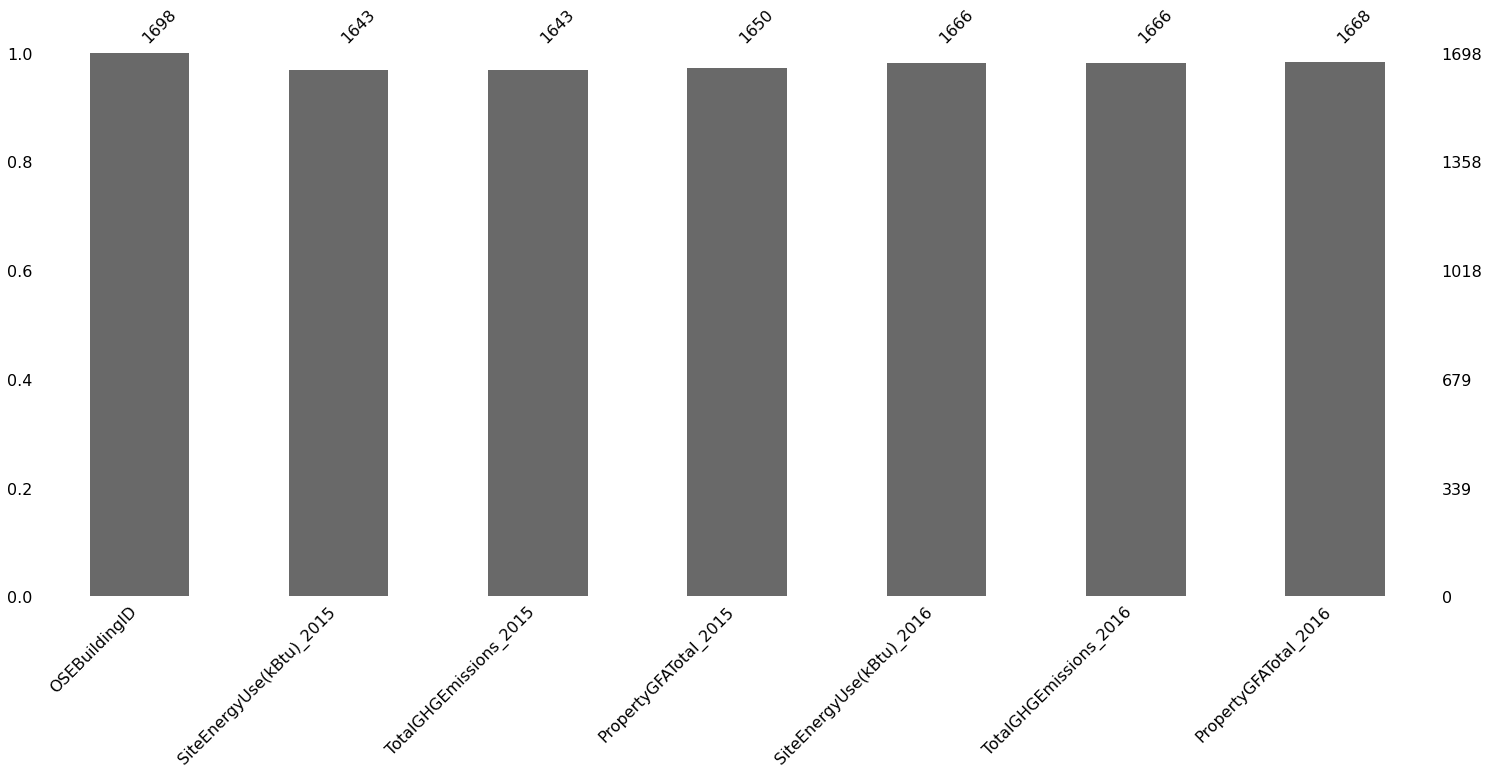

In [163]:
missingno.bar(df_ecart)

In [164]:
df_na2015 = df_ecart[df_ecart['SiteEnergyUse(kBtu)_2015'].isna()]
df_na2015

OSEBuildingID  SiteEnergyUse(kBtu)_2015  TotalGHGEmissions_2015  \
60               87                       NaN                     NaN   
660           19694                       NaN                     NaN   
939           21570                       NaN                     NaN   
940           21578                       NaN                     NaN   
1226          24408                       NaN                     NaN   
1342          25361                       NaN                     NaN   
1345          25451                       NaN                     NaN   
1650             43                       NaN                     NaN   
1651            364                       NaN                     NaN   
1652            365                       NaN                     NaN   
1653            750                       NaN                     NaN   
1654          20377                       NaN                     NaN   
1655          20978                       NaN                     NaN   
1656          21103                       NaN                     NaN   
1657          23964                       NaN                     NaN   
1658          24418                       NaN                     NaN   
1659          49715                       NaN                     NaN   
1660          49716                       NaN                     NaN   
1661          49967                       NaN                     NaN   
1662          49968                       NaN                     NaN   
1663          49970                       NaN                     NaN   
1664          49972                       NaN                     NaN   
1665          49979                       NaN                     NaN   
1666          49980                       NaN                     NaN   
1667          49983                       NaN                     NaN   
1668          50026                       NaN                     NaN   
1669          50031                       NaN                     NaN   
1670          50035                       NaN                     NaN   
1671          50037                       NaN                     NaN   
1672          50039                       NaN                     NaN   
1673          50045                       NaN                     NaN   
1674          50054                       NaN                     NaN   
1675          50062                       NaN                     NaN   
1676          50068                       NaN                     NaN   
1677          50069                       NaN                     NaN   
1678          50070                       NaN                     NaN   
1679          50081                       NaN                     NaN   
1680          50094                       NaN                     NaN   
1681          50101                       NaN                     NaN   
1682          50196                       NaN                     NaN   
1683          50198                       NaN                     NaN   
1684          50201                       NaN                     NaN   
1685          50204                       NaN                     NaN   
1686          50207                       NaN                     NaN   
1687          50208                       NaN                     NaN   
1688          50210                       NaN                     NaN   
1689          50212                       NaN                     NaN   
1690          50219                       NaN                     NaN   
1691          50220                       NaN                     NaN   
1692          50221                       NaN                     NaN   
1693          50222                       NaN                     NaN   
1694          50223                       NaN                     NaN   
1695          50224                       NaN                     NaN   
1696          50225                       NaN                   

In [165]:
df_na2016 = df_ecart[df_ecart['SiteEnergyUse(kBtu)_2016'].isna()]
df_na2016

OSEBuildingID  SiteEnergyUse(kBtu)_2015  TotalGHGEmissions_2015  \
196             325                 9898724.0                   69.01   
264             400                 6525887.0                   47.24   
304             442                16760217.0                  116.84   
350             499                 4476997.0                  134.69   
397             559                12662456.0                  226.92   
398             560                 1575581.0                   11.09   
489             675                55030192.0                 1891.47   
518             714                 6669954.0                  260.94   
567             773                 2982178.0                   35.69   
581             790                 1008645.0                   39.08   
615             838                 6668456.0                  231.39   
658           19656                  133880.0                    0.93   
659           19658                  841242.0                   12.91   
675           19780                 6293359.0                  232.12   
861           21237                 1392153.0                   35.11   
915           21471                  413919.0                    4.43   
952           21688                 1231546.0                   36.72   
969           21796                 2539565.0                   64.95   
994           22138                   91996.0                    0.64   
1014          22441                 2547582.0                   45.90   
1015          22446                  238255.0                    3.59   
1077          23163                 1798899.0                   12.54   
1135          23848                 3816695.0                  119.01   
1226          24408                       NaN                     NaN   
1308          24904                  595839.0                   16.59   
1324          25042                  662012.0                   22.78   
1347          25455                 4291789.0                  137.23   
1369          25654                  184077.0                    1.28   
1441          26532                  950078.0                    6.62   
1531          27639                 3058638.0                   95.20   
1542          27829                  799996.0                    5.58   
1630          49859               157606480.0                 4829.86   

      PropertyGFATotal_2015  SiteEnergyUse(kBtu)_2016  TotalGHGEmissions_2016  \
196                111077.0                       NaN                     NaN   
264                 98370.0                       NaN                     NaN   
304                193788.0                       NaN                     NaN   
350                 76598.0                       NaN                     NaN   
397                186971.0                       NaN                     NaN   
398                 66968.0                       NaN                     NaN   
489                434475.0                       NaN                     NaN   
518                192960.0                       NaN                     NaN   
567                 63150.0                       NaN                     NaN   
581                 54171.0                       NaN                     NaN   
615                 83448.0                       NaN                     NaN   
658                 21600.0                       NaN                     NaN   
659                 28568.0                       NaN                     NaN   
675                 21633.0                       NaN                     NaN   
861                 23696.0                       NaN                     NaN   
915                 44928.0                       NaN                     NaN   
952                 27435.0                       NaN                     NaN   
969                 83882.0                       NaN                     NaN   
994                 22029.0                       NaN    

<AxesSubplot:>

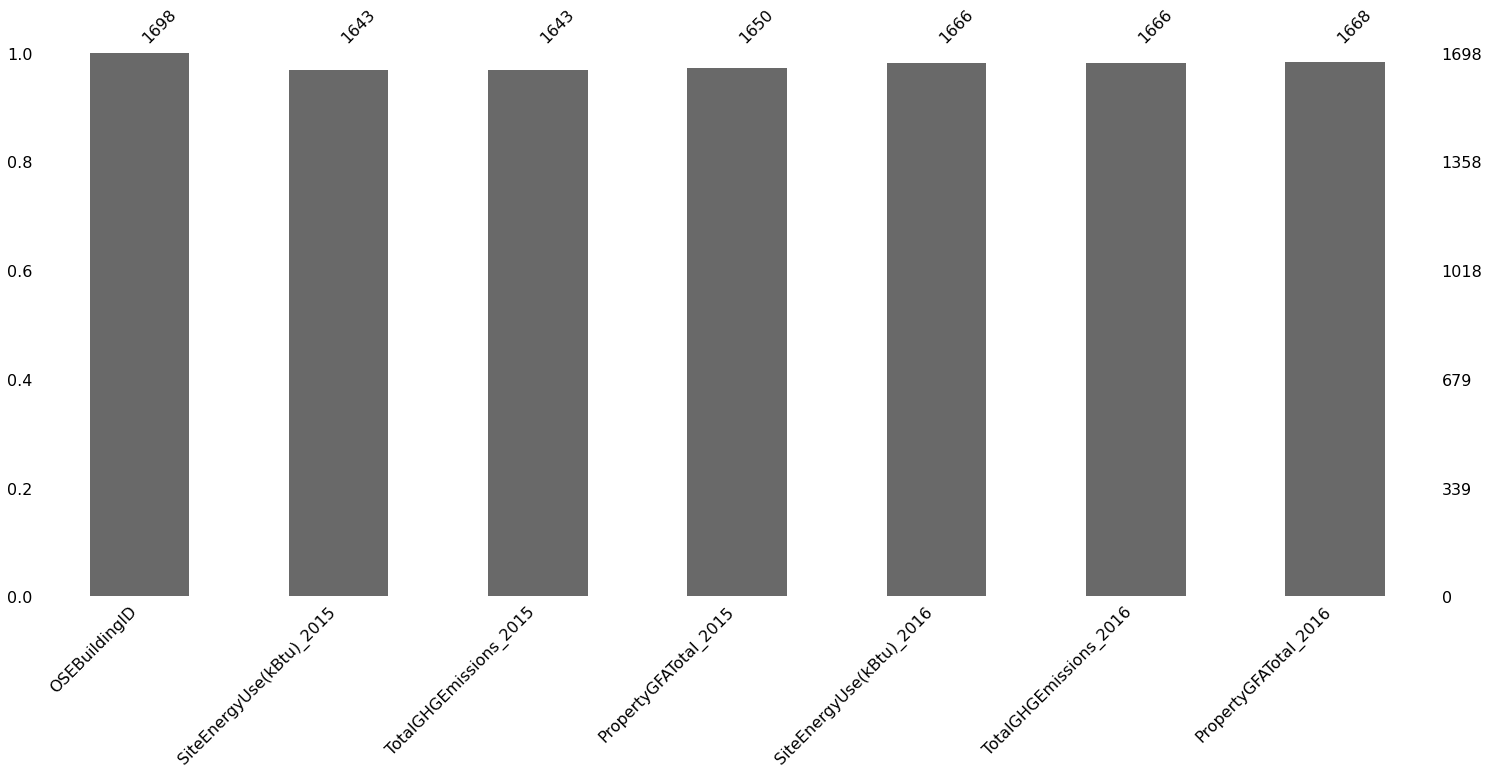

In [166]:
missingno.bar(df_ecart)

### Calcul des écarts

In [167]:
df_ecart['Ecart_Energie'] = df_ecart['SiteEnergyUse(kBtu)_2016'] - df_ecart['SiteEnergyUse(kBtu)_2015']
df_ecart['Ecart_Emissions'] = df_ecart['TotalGHGEmissions_2016'] - df_ecart['TotalGHGEmissions_2015']
df_ecart['Ecart_PropertyGFATotal'] = df_ecart['PropertyGFATotal_2016'] - df_ecart['PropertyGFATotal_2015']

Seul les écarts nous intéressent dans df_ecart

In [168]:
df_ecart

OSEBuildingID  SiteEnergyUse(kBtu)_2015  TotalGHGEmissions_2015  \
0                 1                 6981428.0                  249.43   
1                 2                 8354235.0                  263.51   
2                 3                73130656.0                 2061.48   
3                 5                28229320.0                 1936.34   
4                 8                14829099.0                  507.70   
...             ...                       ...                     ...   
1693          50222                       NaN                     NaN   
1694          50223                       NaN                     NaN   
1695          50224                       NaN                     NaN   
1696          50225                       NaN                     NaN   
1697          50226                       NaN                     NaN   

      PropertyGFATotal_2015  SiteEnergyUse(kBtu)_2016  TotalGHGEmissions_2016  \
0                   88434.0              7.226362e+06                  249.98   
1                  103566.0              8.387933e+06                  295.86   
2                  961990.0              7.258702e+07                 2089.28   
3                   61320.0              6.794584e+06                  286.43   
4                  119890.0              1.417261e+07                  505.01   
...                     ...                       ...                     ...   
1693                    NaN              8.497457e+05                   20.94   
1694                    NaN              9.502762e+05                   32.17   
1695                    NaN              5.765898e+06                  223.54   
1696                    NaN              7.194712e+05                   22.11   
1697                    NaN              1.152896e+06                   41.27   

      PropertyGFATotal_2016  Ecart_Energie  Ecart_Emissions  \
0                   88434.0       244934.5             0.55   
1                  103566.0        33698.0            32.35   
2                  956110.0      -543632.0            27.80   
3                   61320.0    -21434736.0         -1649.91   
4                  175580.0      -656493.0            -2.69   
...                     ...            ...              ...   
1693                12294.0            NaN              NaN   
1694                16000.0            NaN              NaN   
1695                13157.0            NaN              NaN   
1696                14101.0            NaN              NaN   
1697                18258.0            NaN              NaN   

      Ecart_PropertyGFATotal  
0                        0.0  
1                        0.0  
2                    -5880.0  
3                        0.0  
4                    55690.0  
...                      ...  
1693                     NaN  
1694                     NaN  
1695                     NaN  
1696                     NaN  
1697                     NaN  

[1698 rows x 10 columns]

### Ajout des écarts à notre dataframe

In [169]:
df = df.merge(df_ecart, on='OSEBuildingID')


In [170]:
df

OSEBuildingID  DataYear        BuildingType PrimaryPropertyType  \
0                 1      2016      NonResidential               Hotel   
1                 2      2016      NonResidential               Hotel   
2                 3      2016      NonResidential               Hotel   
3                 5      2016      NonResidential               Hotel   
4                 8      2016      NonResidential               Hotel   
...             ...       ...                 ...                 ...   
1693          50222      2016  Nonresidential COS              Office   
1694          50223      2016  Nonresidential COS               Other   
1695          50224      2016  Nonresidential COS               Other   
1696          50225      2016  Nonresidential COS  Mixed Use Property   
1697          50226      2016  Nonresidential COS  Mixed Use Property   

               Neighborhood  YearBuilt  NumberofBuildings  NumberofFloors  \
0                  DOWNTOWN       1927                1.0            12.0   
1                  DOWNTOWN       1996                1.0            11.0   
2                  DOWNTOWN       1969                1.0            41.0   
3                  DOWNTOWN       1926                1.0            10.0   
4                  DOWNTOWN       1980                1.0            18.0   
...                     ...        ...                ...             ...   
1693       GREATER DUWAMISH       1990                1.0             1.0   
1694               DOWNTOWN       2004                1.0             1.0   
1695  MAGNOLIA / QUEEN ANNE       1974                1.0             1.0   
1696       GREATER DUWAMISH       1989                1.0             1.0   
1697       GREATER DUWAMISH       1938                1.0             1.0   

      PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
0                88434                   0                   88434   
1               103566               15064                   88502   
2               956110              196718                  759392   
3                61320                   0                   61320   
4               175580               62000                  113580   
...                ...                 ...                     ...   
1693             12294                   0                   12294   
1694             16000                   0                   16000   
1695             13157                   0                   13157   
1696             14101                   0                   14101   
1697             18258                   0                   18258   

                              ListOfAllPropertyUseTypes  \
0                                                 Hotel   
1                            Hotel, Parking, Restaurant   
2                                                 Hotel   
3                                                 Hotel   
4                         Hotel, Parking, Swimming Pool   
...                                                 ...   
1693                                             Office   
1694                                 Other - Recreation   
1695  Fitness Center/Health Club/Gym, Other - Recrea...   
1696  Fitness Center/Health Club/Gym, Food Service, ...   
1697  Fitness Center/Health Club/Gym, Food Service, ...   

     LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                     Hotel                    88434.0   
1                     Hotel                    83880.0   
2                     Hotel                   756493.0   
3                     Hotel                    61320.0   
4                     Hotel                   123445.0   
...                     ...                        ...   
1693                 Office                    12294.0   
1694     Other - Recreation                    16000.0   
1695     Other - Recreation                     7583.0   
1696     Other - Recreation                     6601.0   
1697     Other -

### Identifier des cas particuliers
#### Ecart Energie

In [171]:
color_scale = ["red", "green", "red"]

fig = px.scatter(df, y="Ecart_Energie", color="Ecart_Energie", text="OSEBuildingID", color_continuous_scale=color_scale)
fig.show()

In [172]:
col = ['OSEBuildingID', 'SiteEnergyUse(kBtu)_2015', 'SiteEnergyUse(kBtu)_2016', 'Ecart_Energie']
df_ecart[(df_ecart['Ecart_Energie'] > 20000000) | (df_ecart['Ecart_Energie'] < -20000000)][col]

OSEBuildingID  SiteEnergyUse(kBtu)_2015  SiteEnergyUse(kBtu)_2016  \
3                 5                28229320.0                 6794584.0   
225             355                37527176.0                69519808.0   
297             435                77164568.0                       0.0   
593             803                 2019254.0                37951708.0   
1334          25251                61984596.0                90609640.0   
1641          49940                78652064.0               163945984.0   

      Ecart_Energie  
3       -21434736.0  
225      31992632.0  
297     -77164568.0  
593      35932454.0  
1334     28625044.0  
1641     85293920.0

#### Ecart Emissions

In [173]:
fig = px.scatter(df, y="Ecart_Emissions", color="Ecart_Emissions", color_continuous_scale=color_scale)
fig.show()

In [174]:
col = ['OSEBuildingID', 'TotalGHGEmissions_2015', 'TotalGHGEmissions_2016', 'Ecart_Emissions']
df_ecart[(df_ecart['Ecart_Emissions'] > 1500) | (df_ecart['Ecart_Emissions'] < -1500)][col]

OSEBuildingID  TotalGHGEmissions_2015  TotalGHGEmissions_2016  \
3                 5                 1936.34                  286.43   
297             435                 1793.90                    0.00   
1334          25251                 2205.24                 3768.66   
1641          49940                 3894.01                 6330.91   

      Ecart_Emissions  
3            -1649.91  
297          -1793.90  
1334          1563.42  
1641          2436.90

On retrouve plusieurs fois :

 batiment 5

batiment 49940

 batiment 25251

 batiment 435

#### Ecart superficie totale

In [175]:
fig = px.scatter(df, y="Ecart_PropertyGFATotal", color="Ecart_PropertyGFATotal", color_continuous_scale=color_scale)
fig.show()

In [176]:
col = ['OSEBuildingID', 'PropertyGFATotal_2015', 'PropertyGFATotal_2016', 'Ecart_PropertyGFATotal']
df_ecart[(df_ecart['Ecart_PropertyGFATotal'] > 50000) | (df_ecart['Ecart_PropertyGFATotal'] < -50000)][col]

OSEBuildingID  PropertyGFATotal_2015  PropertyGFATotal_2016  \
4                 8               119890.0               175580.0   
63               96               187600.0                99780.0   
67              103               129000.0               389000.0   
227             357              1195387.0              1354987.0   
351             500               244529.0               308965.0   
498             689               140000.0                81336.0   
610             829               215946.0                62600.0   
1175          24086               180796.0               230971.0   

      Ecart_PropertyGFATotal  
4                    55690.0  
63                  -87820.0  
67                  260000.0  
227                 159600.0  
351                  64436.0  
498                 -58664.0  
610                -153346.0  
1175                 50175.0

Pas forcément les batiments observés précédemment...

# Suppression colonnes vides

<span style="color: #FF7F00">Après tous ces traitements, de quoi disposons-nous ?</span>

In [177]:
# Avec ces manipulations, d'autres colonnes paraissent inutiles. On les supprime.
df = supprimer_variables_peu_utilisables(df, 0.7)

La colonne OtherFuelUse(kBtu) , avec 98.29210836277974 % de données manquantes de la Dataframe est supprimée
La colonne Seattle Police Department Micro Community Policing Plan Areas , avec 98.23321554770318 % de données manquantes de la Dataframe est supprimée
La colonne SPD Beats , avec 98.23321554770318 % de données manquantes de la Dataframe est supprimée
La colonne Zip Codes , avec 98.23321554770318 % de données manquantes de la Dataframe est supprimée


In [178]:
df

OSEBuildingID  DataYear        BuildingType PrimaryPropertyType  \
0                 1      2016      NonResidential               Hotel   
1                 2      2016      NonResidential               Hotel   
2                 3      2016      NonResidential               Hotel   
3                 5      2016      NonResidential               Hotel   
4                 8      2016      NonResidential               Hotel   
...             ...       ...                 ...                 ...   
1693          50222      2016  Nonresidential COS              Office   
1694          50223      2016  Nonresidential COS               Other   
1695          50224      2016  Nonresidential COS               Other   
1696          50225      2016  Nonresidential COS  Mixed Use Property   
1697          50226      2016  Nonresidential COS  Mixed Use Property   

               Neighborhood  YearBuilt  NumberofBuildings  NumberofFloors  \
0                  DOWNTOWN       1927                1.0            12.0   
1                  DOWNTOWN       1996                1.0            11.0   
2                  DOWNTOWN       1969                1.0            41.0   
3                  DOWNTOWN       1926                1.0            10.0   
4                  DOWNTOWN       1980                1.0            18.0   
...                     ...        ...                ...             ...   
1693       GREATER DUWAMISH       1990                1.0             1.0   
1694               DOWNTOWN       2004                1.0             1.0   
1695  MAGNOLIA / QUEEN ANNE       1974                1.0             1.0   
1696       GREATER DUWAMISH       1989                1.0             1.0   
1697       GREATER DUWAMISH       1938                1.0             1.0   

      PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
0                88434                   0                   88434   
1               103566               15064                   88502   
2               956110              196718                  759392   
3                61320                   0                   61320   
4               175580               62000                  113580   
...                ...                 ...                     ...   
1693             12294                   0                   12294   
1694             16000                   0                   16000   
1695             13157                   0                   13157   
1696             14101                   0                   14101   
1697             18258                   0                   18258   

                              ListOfAllPropertyUseTypes  \
0                                                 Hotel   
1                            Hotel, Parking, Restaurant   
2                                                 Hotel   
3                                                 Hotel   
4                         Hotel, Parking, Swimming Pool   
...                                                 ...   
1693                                             Office   
1694                                 Other - Recreation   
1695  Fitness Center/Health Club/Gym, Other - Recrea...   
1696  Fitness Center/Health Club/Gym, Food Service, ...   
1697  Fitness Center/Health Club/Gym, Food Service, ...   

     LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                     Hotel                    88434.0   
1                     Hotel                    83880.0   
2                     Hotel                   756493.0   
3                     Hotel                    61320.0   
4                     Hotel                   123445.0   
...                     ...                        ...   
1693                 Office                    12294.0   
1694     Other - Recreation                    16000.0   
1695     Other - Recreation                     7583.0   
1696     Other - Recreation                     6601.0   
1697     Other -

# Construction du Dataset final

<span style="color: #FF7F00">Intérêt de ces variables ?</span>

In [179]:
df[['OSEBuildingID', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']]
# df[['SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']] = df[['SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']].fillna('Non précisé')


OSEBuildingID    SecondLargestPropertyUseType  \
0                 1                             NaN   
1                 2                         Parking   
2                 3                             NaN   
3                 5                             NaN   
4                 8                         Parking   
...             ...                             ...   
1693          50222                             NaN   
1694          50223                             NaN   
1695          50224  Fitness Center/Health Club/Gym   
1696          50225  Fitness Center/Health Club/Gym   
1697          50226  Fitness Center/Health Club/Gym   

     ThirdLargestPropertyUseType  
0                            NaN  
1                     Restaurant  
2                            NaN  
3                            NaN  
4                  Swimming Pool  
...                          ...  
1693                         NaN  
1694                         NaN  
1695               Swimming Pool  
1696          Pre-school/Daycare  
1697          Pre-school/Daycare  

[1698 rows x 3 columns]

In [180]:
df[['OSEBuildingID', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']].isna().sum()

OSEBuildingID                      0
SecondLargestPropertyUseType     832
ThirdLargestPropertyUseType     1342
dtype: int64

<span style="color: #00B0F0"> Maintenant que nous avons la moyenne, des colonnes sont inutiles, voire redondantes. </span>

<span style="color: #26B260"> Les nan dans les variables 2015-2016 peuvent être également supprimés puisque nous les avons expliqués précédemment. </span>

In [181]:
# note : on ne garde pas otherfueluse qui est réapparu car l'énoncé nous demande justement de le supprimer
# on ne veut pas rendre trop compliqué notre modèle, donc on va prendre LargestPropertyUseType
# PrimaryPropertyType et LargestPropertyUseType sont quasiment similaires, n'en garder qu'une
# et on va laisser de côté second et third pour plus de simplicité
colonne_à_garder = ['OSEBuildingID', 'DataYear', 'BuildingType', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
                    'Latitude', 'Longitude', 'LargestPropertyUseType', 'PropertyGFATotal_avg', 'PropertyGFAParking_avg',
                    'PropertyGFABuilding(s)_avg', 'LargestPropertyUseTypeGFA_avg',
                    'SiteEnergyUse(kBtu)_avg',
                    'TotalGHGEmissions_avg']



# On prend Energystarscore car l'énoncé nous demande de justifier l'impact de cette variable
# ici je ne le garde pas car insuffisamment complété (il manque 30% du dataset, ce qui supprime 500 batiments)
# https://www.energystar.gov/buildings/benchmark/analyze_benchmarking_results


df_energystar = df.copy()

df = df[colonne_à_garder]

# Energystarscore a moins de données (1180 environ vs 1697 sans utiliser cette variable). On va donc les dissocier.
df_energystar = df_energystar[colonne_à_garder + ['ENERGYSTARScore']]


<AxesSubplot:>

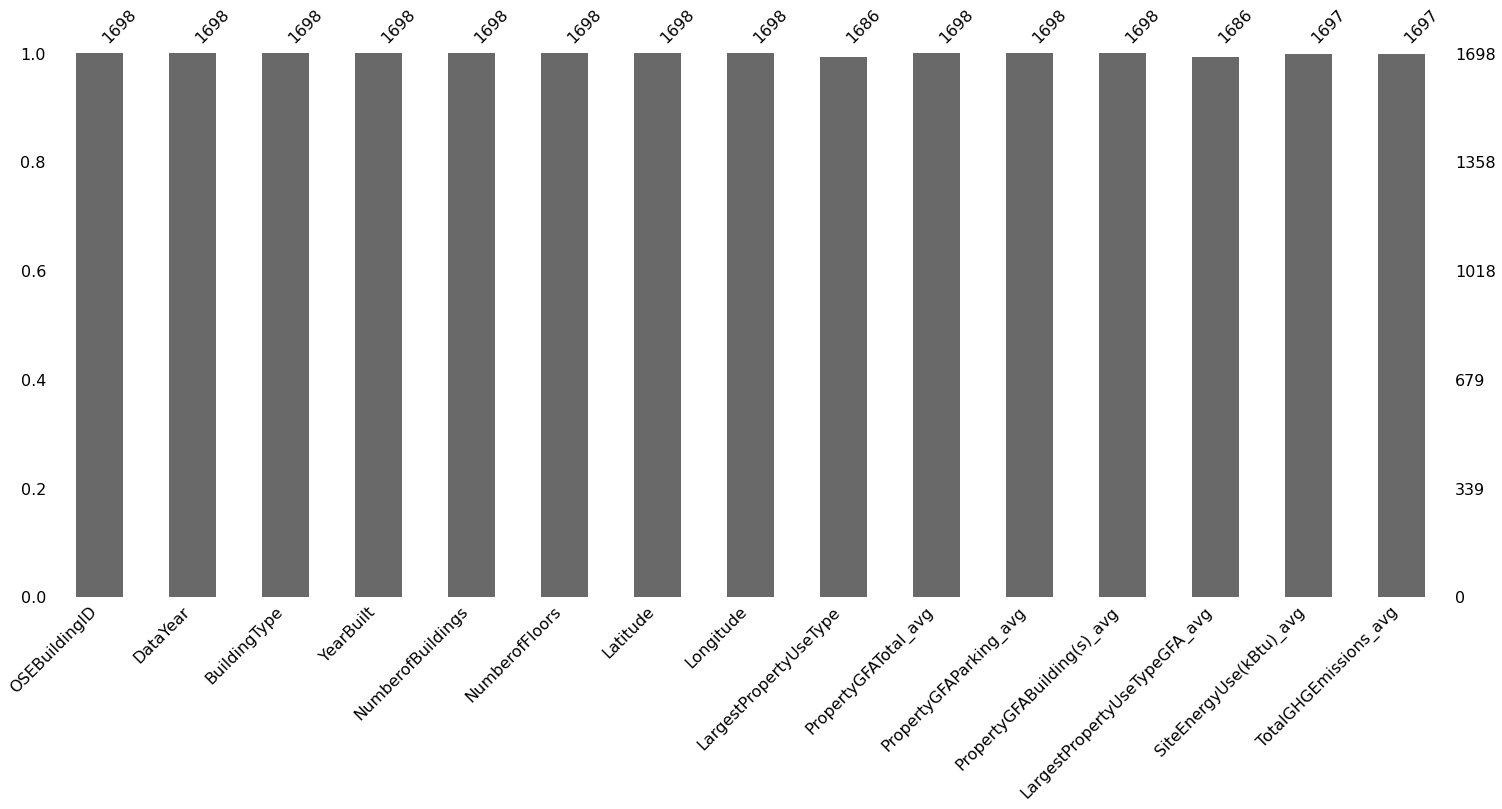

In [182]:
missingno.bar(df)

<AxesSubplot:>

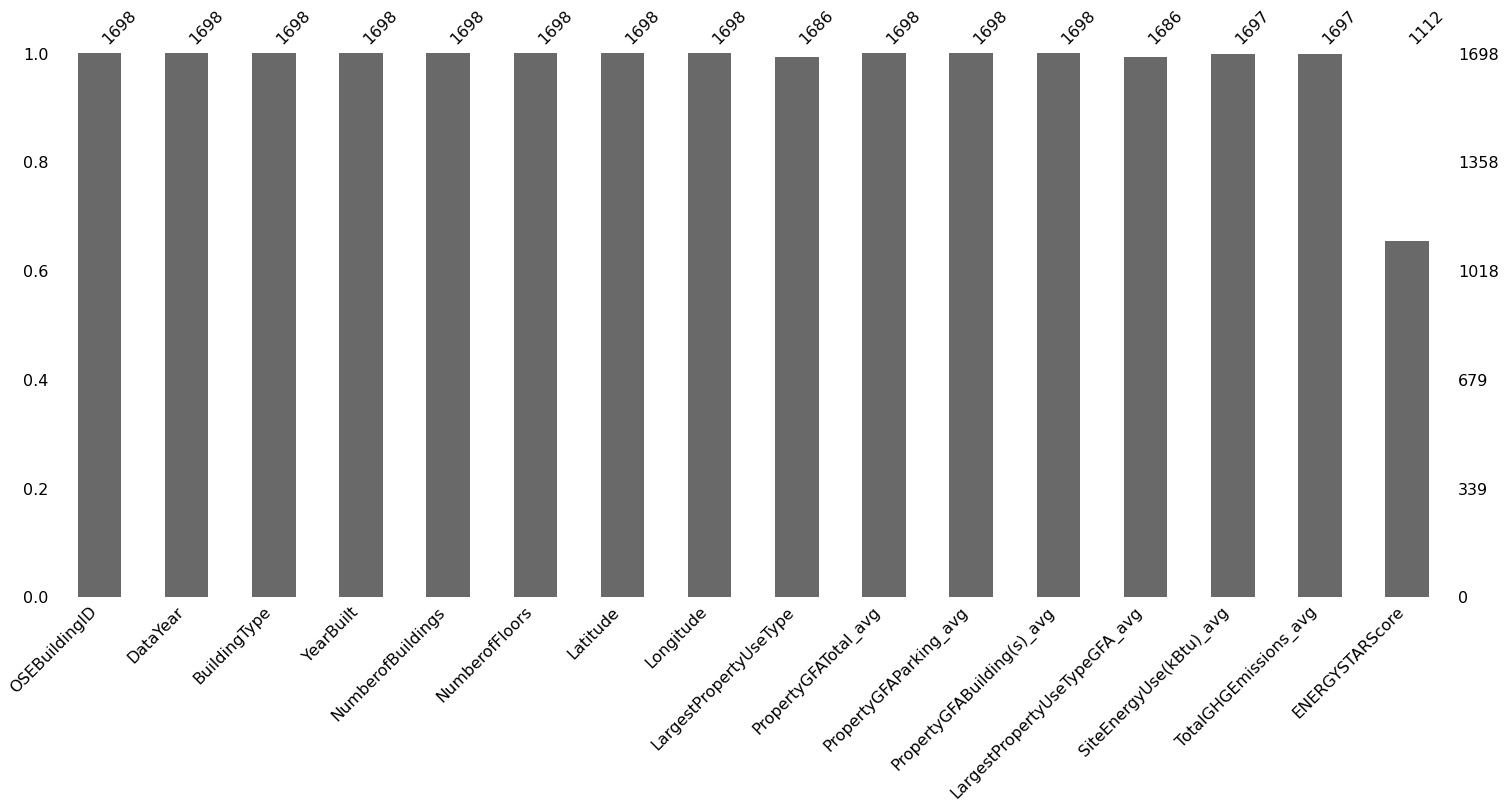

In [183]:
missingno.bar(df_energystar)

## Features Engineering
### PropertyGFA
<span style="color: #00B0F0">On va remplacer le propertyGFAParking / propertyGFABuilding par le %. C'est plus lisible. </span>

In [184]:
def propertyGFAConversion(df):
    df['PropertyGFABuilding(s)_%'] = round(df['PropertyGFABuilding(s)_avg'] / df['PropertyGFATotal_avg'],2)
    df['PropertyGFAParking_%'] = round(df['PropertyGFAParking_avg'] / df['PropertyGFATotal_avg'],2)
    return df
    
df = propertyGFAConversion(df)
df_energystar = propertyGFAConversion(df_energystar)


### LargestPropertyUseType

In [185]:
def mapping_largestproperty(df):
#Ce mapping réduit le score des prédictions (map ou replace)
    df['LargestPropertyUseType'] = df['LargestPropertyUseType'].replace(
                        {'Retail Store' : 'Commerce',
                        'Supermarket/Grocery Store' : 'Commerce',
                        'Repair Services (Vehicle, Shoe, Locksmith, etc)' : 'Commerce',
                        'Automobile Dealership': 'Commerce',
                        'Convenience Store without Gas Station': 'Commerce',
                        'Personal Services': 'Commerce',
                        'Enclosed Mall': 'Commerce',
                        'Strip Mall': 'Commerce',
                        'Wholesale Club/Supercenter': 'Commerce',
                        'Other - Mall': 'Commerce',
                        'Supermarket / Grocery Stor': 'Commerce',
                        
                        'Food Sales': 'Nourriture',
                        'Restaurant' : 'Nourriture',
                        'Other - Restaurant/Bar' : 'Nourriture',
                        'Food Service': 'Nourriture' ,

                        'Worship Facility': 'Loisirs',
                        'Other - Recreation': 'Loisirs',
                        'Other - Entertainment/Public Assembly': 'Loisirs',
                        'Performing Arts': 'Loisirs',
                        'Bar/Nightclub': 'Loisirs',
                        'Movie Theater': 'Loisirs',
                        'Museum': 'Loisirs',
                        'Social/Meeting Hall': 'Loisirs',
                        'Fitness Center/Health Club/Gym': 'Loisirs',
                        'Lifestyle Center ': 'Loisirs',
                        'Fast Food Restaurant': 'Loisirs',
                        
                        'Multifamily Housing' : 'Hotel/Senior Care',
                        'Other - Lodging/Residential': 'Hotel/Senior Care',
                        'Residence Hall/Dormitory': 'Hotel/Senior Care',
                        'Hotel' : 'Hotel/Senior Care/Housing',
                        'Senior Care Community' : 'Hotel/Senior Care',
                        'Residential Care Facility' : 'Hotel/Senior Care',
                        'High-Rise Multifamily': 'Hotel/Senior Care',
                        
                        'Medical Office' : 'Santé',
                        
                        'Other - Services' : 'Office',
                        'Bank Branch' : 'Office',
                        'Financial Office' : 'Office',
                        'Other - Public Services': 'Office',

                        'K-12 School' : 'Education',
                        'Other - Education': 'Education',
                        'Vocational School' : 'Education', 
                        'Adult Education' : 'Education',
                        'Pre-school/Daycare': 'Education',
                        'University': 'Education',
                        'College/University': 'Education',
                        'Library': 'Education'
                    })
    # on peut compléter les données manquantes string facilement.
    colonne_txt = ['LargestPropertyUseType']
    df[colonne_txt] = df[colonne_txt].fillna('Informations indisponibles', axis=1)
    return df

df = mapping_largestproperty(df)
df_energystar = mapping_largestproperty(df_energystar)



In [186]:
df['LargestPropertyUseType'].value_counts()

Office                                                  522
Non-Refrigerated Warehouse                              200
Education                                               177
Commerce                                                164
Loisirs                                                 148
Other                                                   101
Hotel/Senior Care/Housing                                76
Hotel/Senior Care                                        60
Distribution Center                                      54
Santé                                                    44
Parking                                                  30
Self-Storage Facility                                    27
Nourriture                                               16
Laboratory                                               13
Refrigerated Warehouse                                   12
Informations indisponibles                               12
Hospital (General Medical & Surgical)   

<span class="burk">Il faut le même nombre partout</span>

In [187]:
df.dropna(inplace=True)
df_energystar.dropna(inplace=True)
# on drop car ça veut dire qu'on a pas d'infos sur les deux années

<AxesSubplot:>

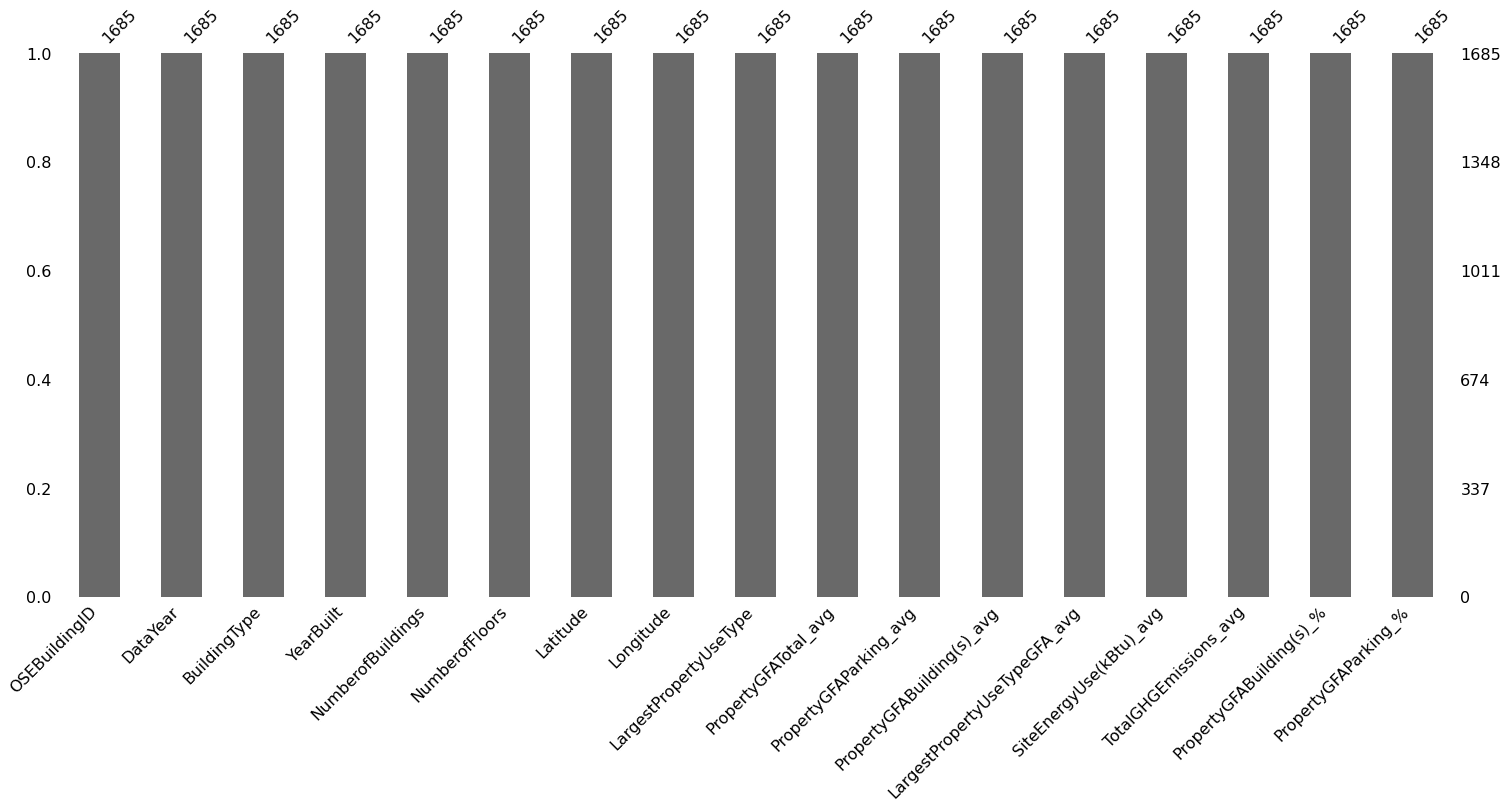

In [188]:
missingno.bar(df)

<AxesSubplot:>

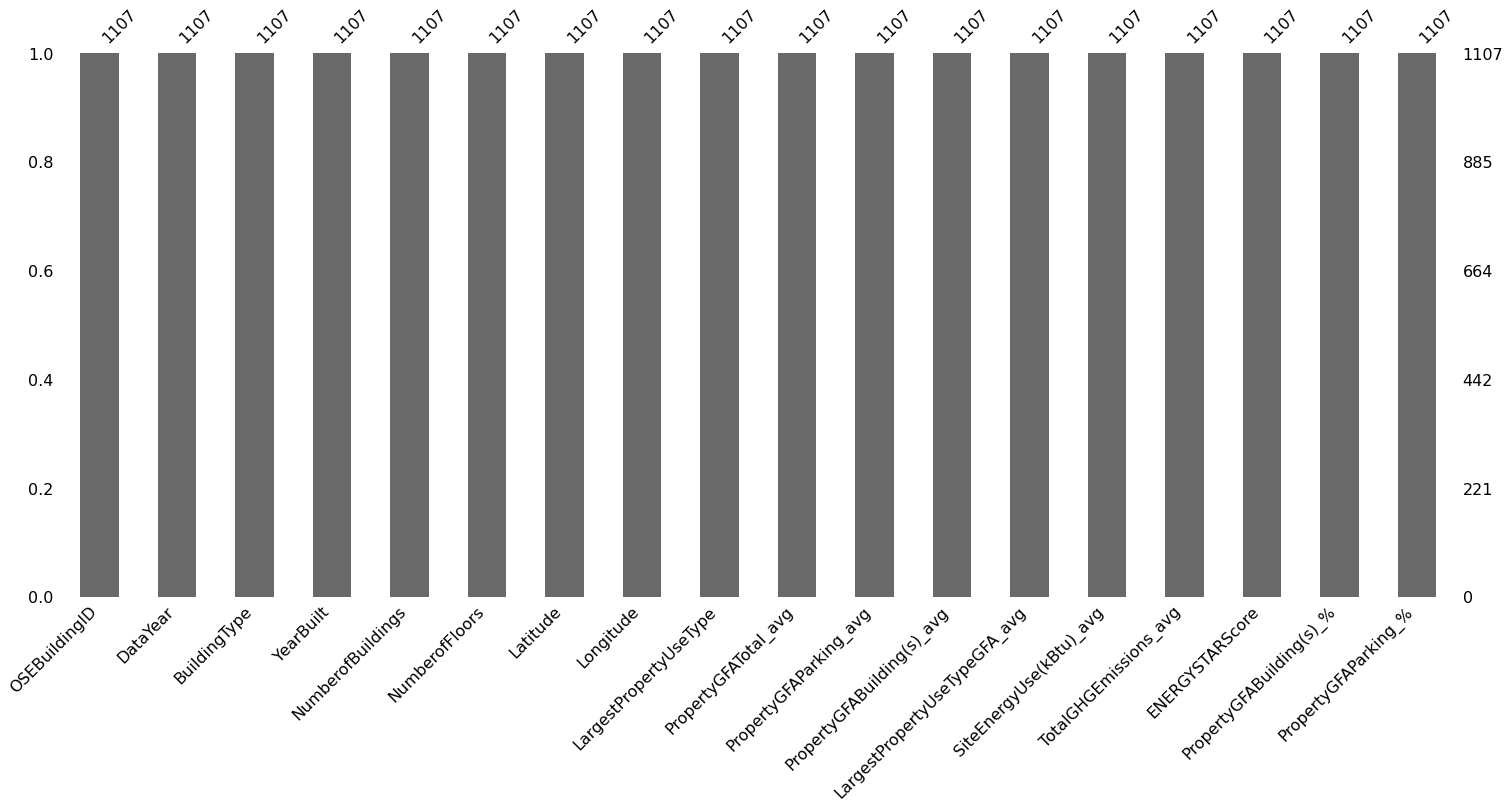

In [189]:
missingno.bar(df_energystar)

### DataYear

In [190]:
def dureedevie(df):
    df['Dureedevie'] = df['DataYear']-df['YearBuilt']  # Age du batiment
    df.drop(['DataYear', 'YearBuilt'], axis=1, inplace=True)
    return df
    
df = dureedevie(df)
df_energystar = dureedevie(df_energystar)

## Suppression consommations égales à 0
<span style="color: #00B0F0"> Dernière vérification... Y a-t-il des conso nulles ? </span>

In [191]:
df[(df['SiteEnergyUse(kBtu)_avg'] == 0) | (df['TotalGHGEmissions_avg'] == 0)]


OSEBuildingID       BuildingType  NumberofBuildings  NumberofFloors  \
61             87  SPS-District K-12                1.0             2.0   

    Latitude  Longitude LargestPropertyUseType  PropertyGFATotal_avg  \
61   47.5097 -122.37759              Education               53352.0   

    PropertyGFAParking_avg  PropertyGFABuilding(s)_avg  \
61                     0.0                     53352.0   

    LargestPropertyUseTypeGFA_avg  SiteEnergyUse(kBtu)_avg  \
61                        59460.0                      0.0   

    TotalGHGEmissions_avg  PropertyGFABuilding(s)_%  PropertyGFAParking_%  \
61                   4.19                       1.0                   0.0   

    Dureedevie  
61          68

In [192]:
df.drop(df[df['OSEBuildingID'] == 87].index, inplace=True)
df_energystar.drop(df_energystar[df_energystar['OSEBuildingID'] == 87].index, inplace=True)

# Analyse exploratoire


## Map interactive
On selectionne nos données...

In [193]:
df_coordonnees = df[['BuildingType', 'Latitude', 'Longitude']]

On va initialiser la map...

In [194]:
map = folium.Map(location=[df_coordonnees['Latitude'].mean(), df_coordonnees['Longitude'].mean()],
                 zoom_start=11,
                 control_scale=True)


Désormais il faut placer nos points...

In [195]:
# Note : J'ai mis head(50) car mon navigateur a quelques difficultés lorque je mets tous les points..

for index, localisation in df_coordonnees.iterrows():
    folium.Circle([localisation['Latitude'],
                   localisation['Longitude']],
                   popup=localisation['BuildingType'], radius=50).add_to(map)

    # circle en fonction de la conso

In [196]:
map

## Différence 2015-2016

### Ensemble des données

In [197]:
df_avec_doublon.sort_values(by=['OSEBuildingID'])

OSEBuildingID  DataYear        BuildingType PrimaryPropertyType  \
0                 1      2015      NonResidential               Hotel   
0                 1      2016      NonResidential               Hotel   
1                 2      2015      NonResidential               Hotel   
1                 2      2016      NonResidential               Hotel   
2                 3      2015      NonResidential               Hotel   
...             ...       ...                 ...                 ...   
3371          50222      2016  Nonresidential COS              Office   
3372          50223      2016  Nonresidential COS               Other   
3373          50224      2016  Nonresidential COS               Other   
3374          50225      2016  Nonresidential COS  Mixed Use Property   
3375          50226      2016  Nonresidential COS  Mixed Use Property   

               Neighborhood  YearBuilt  NumberofBuildings  NumberofFloors  \
0                  DOWNTOWN       1927                1.0            12.0   
0                  DOWNTOWN       1927                1.0            12.0   
1                  DOWNTOWN       1996                1.0            11.0   
1                  DOWNTOWN       1996                1.0            11.0   
2                  DOWNTOWN       1969                1.0            41.0   
...                     ...        ...                ...             ...   
3371       GREATER DUWAMISH       1990                1.0             1.0   
3372               DOWNTOWN       2004                1.0             1.0   
3373  MAGNOLIA / QUEEN ANNE       1974                1.0             1.0   
3374       GREATER DUWAMISH       1989                1.0             1.0   
3375       GREATER DUWAMISH       1938                1.0             1.0   

      PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
0                88434                   0                   88434   
0                88434                   0                   88434   
1               103566               15064                   88502   
1               103566               15064                   88502   
2               961990                   0                  961990   
...                ...                 ...                     ...   
3371             12294                   0                   12294   
3372             16000                   0                   16000   
3373             13157                   0                   13157   
3374             14101                   0                   14101   
3375             18258                   0                   18258   

                              ListOfAllPropertyUseTypes  \
0                                                 Hotel   
0                                                 Hotel   
1                            Hotel, Parking, Restaurant   
1                            Hotel, Parking, Restaurant   
2                         Hotel, Parking, Swimming Pool   
...                                                 ...   
3371                                             Office   
3372                                 Other - Recreation   
3373  Fitness Center/Health Club/Gym, Other - Recrea...   
3374  Fitness Center/Health Club/Gym, Food Service, ...   
3375  Fitness Center/Health Club/Gym, Food Service, ...   

     LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                     Hotel                    88434.0   
0                     Hotel                    88434.0   
1                     Hotel                    83880.0   
1                     Hotel                    83880.0   
2                     Hotel                   757243.0   
...                     ...                        ...   
3371                 Office                    12294.0   
3372     Other - Recreation                    16000.0   
3373     Other - Recreation                     7583.0   
3374     Other - Recreation                     6601.0   
3375     Other -

### Occurences par année

In [198]:
fig = px.pie(df_avec_doublon, names="DataYear", color='DataYear', title='Occurences par année')
fig.update_traces(textinfo='value')

fig.show()

### TotalGHGEmissions par année

In [199]:
fig = px.histogram(df_avec_doublon, x="TotalGHGEmissions", color='DataYear', title='TotalGHGEmissions par année')

fig.show()

#### Echelle log

<span style="color: #00B0F0"> Pas utilisable en l'état... Sur les conseils d'internet, on passe cela sous échelle log </span>

In [200]:
df_log_emissions = echelle_logarithmique(df_avec_doublon, 'TotalGHGEmissions')
fig = px.histogram(df_log_emissions, x="TotalGHGEmissions", color='DataYear', title='TotalGHGEmissions par année')

fig.show()

### SiteEnergyUse par année

In [201]:
fig = px.histogram(df_avec_doublon, x="SiteEnergyUse(kBtu)", color='DataYear', title='SiteEnergyUse par année')

fig.show()

#### Echelle log

In [202]:
df_log_emissions = echelle_logarithmique(df_avec_doublon, 'SiteEnergyUse(kBtu)')

fig = px.histogram(df_log_emissions, x="SiteEnergyUse(kBtu)", color='DataYear', title='SiteEnergyUse par année')

fig.show()


## Répartition et Distribution

In [203]:
df


OSEBuildingID        BuildingType  NumberofBuildings  NumberofFloors  \
0                 1      NonResidential                1.0            12.0   
1                 2      NonResidential                1.0            11.0   
2                 3      NonResidential                1.0            41.0   
3                 5      NonResidential                1.0            10.0   
4                 8      NonResidential                1.0            18.0   
...             ...                 ...                ...             ...   
1693          50222  Nonresidential COS                1.0             1.0   
1694          50223  Nonresidential COS                1.0             1.0   
1695          50224  Nonresidential COS                1.0             1.0   
1696          50225  Nonresidential COS                1.0             1.0   
1697          50226  Nonresidential COS                1.0             1.0   

      Latitude  Longitude     LargestPropertyUseType  PropertyGFATotal_avg  \
0     47.61220 -122.33799  Hotel/Senior Care/Housing               88434.0   
1     47.61317 -122.33393  Hotel/Senior Care/Housing              103566.0   
2     47.61393 -122.33810  Hotel/Senior Care/Housing              959050.0   
3     47.61412 -122.33664  Hotel/Senior Care/Housing               61320.0   
4     47.61375 -122.34047  Hotel/Senior Care/Housing              147735.0   
...        ...        ...                        ...                   ...   
1693  47.56722 -122.31154                     Office               12294.0   
1694  47.59625 -122.32283                    Loisirs               16000.0   
1695  47.63644 -122.35784                    Loisirs               13157.0   
1696  47.52832 -122.32431                    Loisirs               14101.0   
1697  47.53939 -122.29536                    Loisirs               18258.0   

      PropertyGFAParking_avg  PropertyGFABuilding(s)_avg  \
0                        0.0                     88434.0   
1                    15064.0                     88502.0   
2                    98359.0                    860691.0   
3                        0.0                     61320.0   
4                    37230.0                    110505.0   
...                      ...                         ...   
1693                     0.0                     12294.0   
1694                     0.0                     16000.0   
1695                     0.0                     13157.0   
1696                     0.0                     14101.0   
1697                     0.0                     18258.0   

      LargestPropertyUseTypeGFA_avg  SiteEnergyUse(kBtu)_avg  \
0                           88434.0             7.103895e+06   
1                           83880.0             8.371084e+06   
2                          756868.0             7.285884e+07   
3                           61320.0             1.751195e+07   
4                          123445.0             1.450085e+07   
...                             ...                      ...   
1693                        12294.0             8.497457e+05   
1694                        16000.0             9.502762e+05   
1695                         7583.0             5.765898e+06   
1696                         6601.0             7.194712e+05   
1697                         8271.0             1.152896e+06   

      TotalGHGEmissions_avg  PropertyGFABuilding(s)_%  PropertyGFAParking_%  \
0                   249.705                      1.00                  0.00   
1                   279.685                      0.85                  0.15   
2                  2075.380                      0.90                  0.10   
3                  1111.385                      1.00                  0.00   
4                   506.355                      0.75                  0.25   
...                     ...                       ...                   ...   
1693                 20.940                      1.00                  0.00   
1694      

### BuildingType

In [204]:
fig = px.pie(df, names='BuildingType')
fig.show()

### Age des batiments

In [205]:
fig = px.box(df, y="Dureedevie")
fig.show()

In [206]:
fig = px.histogram(df, x="Dureedevie", nbins=20, text_auto=True)
fig.update_layout(bargap=0.2)
fig.show()

### Emissions GHG

In [207]:
fig = px.box(df, x="BuildingType", y="TotalGHGEmissions_avg", title="Boxplot emission", color="BuildingType")
fig.show()

In [208]:
fig = px.scatter(df, x='PropertyGFATotal_avg', y='TotalGHGEmissions_avg', color='BuildingType', title="Emission gaz selon la superficie totale et par Type de batiment")
fig.show()

#### Vérification des outliers

In [209]:
df[df['TotalGHGEmissions_avg'] > 8000]

OSEBuildingID    BuildingType  NumberofBuildings  NumberofFloors  \
34               43          Campus                1.0             3.0   
122             198  NonResidential                6.0            10.0   
167             276  NonResidential                9.0             8.0   
613             828  NonResidential                7.0            14.0   
1657          49967          Campus              111.0             0.0   

       Latitude   Longitude                 LargestPropertyUseType  \
34    47.534930 -122.317880                                 Office   
122   47.662310 -122.281460  Hospital (General Medical & Surgical)   
167   47.603990 -122.323770  Hospital (General Medical & Surgical)   
613   47.608951 -122.322402  Hospital (General Medical & Surgical)   
1657  47.656440 -122.310410                              Education   

      PropertyGFATotal_avg  PropertyGFAParking_avg  \
34                494835.0                     0.0   
122               879000.0                     0.0   
167              1158691.0                     0.0   
613              1765970.0                     0.0   
1657             9320156.0                     0.0   

      PropertyGFABuilding(s)_avg  LargestPropertyUseTypeGFA_avg  \
34                      494835.0                       757027.0   
122                     879000.0                       879000.0   
167                    1158691.0                      1350182.0   
613                    1765970.0                      1639334.0   
1657                   9320156.0                      9320156.0   

      SiteEnergyUse(kBtu)_avg  TotalGHGEmissions_avg  \
34                448385312.0              16870.980   
122               252512144.0               8096.110   
167               294451712.0              10757.605   
613               289149984.0              12066.025   
1657              873923712.0              11140.560   

      PropertyGFABuilding(s)_%  PropertyGFAParking_%  Dureedevie  
34                         1.0                   0.0          24  
122                        1.0                   0.0          63  
167                        1.0                   0.0          16  
613                        1.0                   0.0          22  
1657                       1.0                   0.0         116

### Emissions énergie

Le BTU, ou British Thermal Unit, est une unité d’énergie frigorifique britannique qui est largement utilisée au-delà des pays anglo-saxons et de l’Asie pour désigner la puissance des appareils de climatisation de petite portée. En d’autres termes, il s’agit de l’unité de mesure de la chaleur nécessaire pour élever la température. Elle est notamment utilisée pour désigner la puissance des climatiseurs disposant d’une capacité inférieure à 30 kW.

 

En pratique, en matière d’énergie, on estime qu’un BTU équivaut à 252 calories ou 105 joules. En matière de puissance, un BTU/h équivaut à 0,298 Watt, unité de mesure utilisée en France et globalement à l’international. Autrement dit, un watt correspond à 3,415 BTU. Et 1 kWh équivaut à 3415 BTU/h.

In [210]:
fig = px.box(df, x="BuildingType", y="SiteEnergyUse(kBtu)_avg", color="BuildingType", title="Boxplot Conso Energie")
fig.show()

In [211]:
fig = px.scatter(df, x='PropertyGFATotal_avg', y='SiteEnergyUse(kBtu)_avg', color='BuildingType', title="Conso Energie selon la superficie totale et par Type de batiment")
fig.show()

In [212]:
# df.drop(df[df['PropertyGFATotal_avg'] > 9000000].index,  inplace=True) test pour voir si en supprimant cette valeur extrême, la prédiction est meilleure. (Hypothèse rejetée)

<span style="color: #26B260"> Excepté pour quelques valeurs, la superficie influe peu sur la conso d'énergie </span>

## Corrélation

<function matplotlib.pyplot.show(close=None, block=None)>

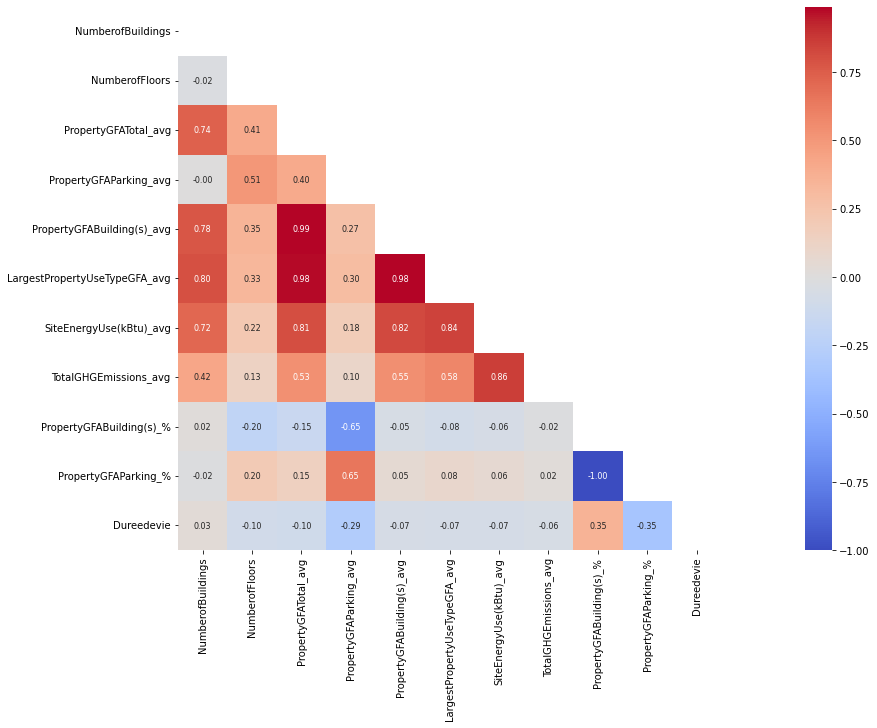

In [213]:
plt.figure(figsize=(30, 10))

colonne_exclusion = ['OSEBuildingID', 'Latitude', 'Longitude']

df_corr = df.drop(columns=colonne_exclusion)

corr_matrix = df_corr.corr()

mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr_matrix, mask=mask, square=True, cmap='coolwarm', annot=True, fmt=".2f", annot_kws={'size': 8})
plt.show

Observations :

- <span style="color: #FF7F00"> Fortes corrélations entre : PropertyGFATotal - PropertyGFABuilding(s) - LargestPropertyUseTypeGFA</span>


- <span style="color: #FF7F00"> Fortes corrélations entre : PropertyGBABuilding(s) - LargestPropertyUseTypeGFA </span>


- <span style="color: #FF7F00">Fortes corrélations entre : TotalGHGEmissions - SiteEnergyUse(kBtu)</span>

<span style="color: #F00000">Note : On ne se base pas sur les corrélations pour selectionner les variables pour la prédiction. ( faire multicorralité)</span>

<function matplotlib.pyplot.show(close=None, block=None)>

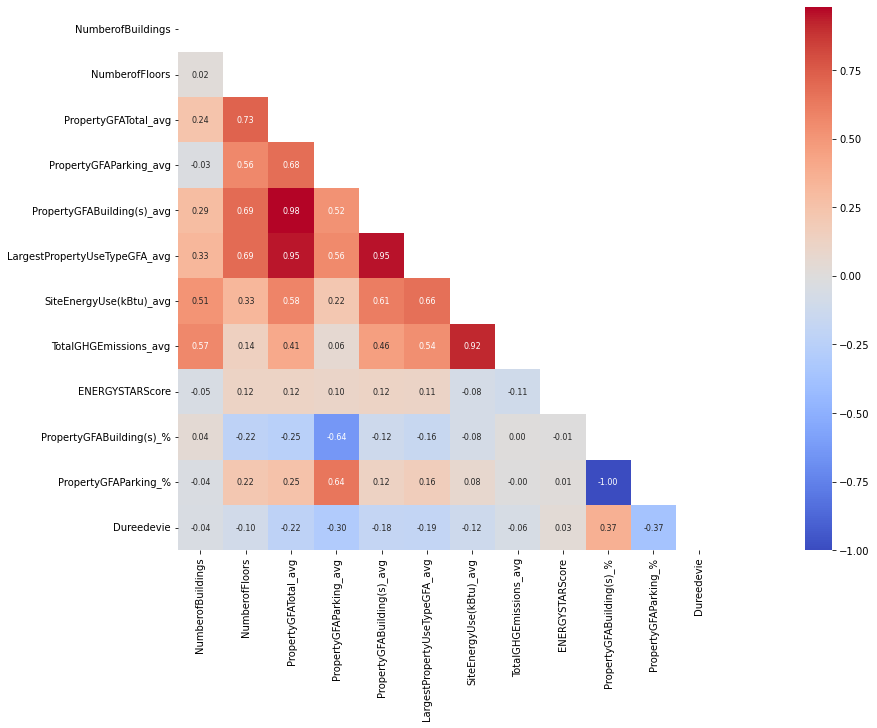

In [214]:
plt.figure(figsize=(30, 10))

colonne_exclusion = ['OSEBuildingID', 'Latitude', 'Longitude']

df_corr = df_energystar.drop(columns=colonne_exclusion)

corr_matrix = df_corr.corr()

mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr_matrix, mask=mask, square=True, cmap='coolwarm', annot=True, fmt=".2f", annot_kws={'size': 8})
plt.show

# Sauvegarde
On a fini la partie exploratoire. On va enregistrer le fichier pour faire nos prédictions.

In [215]:
df.to_csv('./data_final.csv', index=False)
df_energystar.to_csv('./data_energystar.csv', index=False)